In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 

\begin{equation}
u = u_0 \mathbb{I} + i u_j \bar{\sigma}_j = 
\begin{pmatrix}
u_0 + i u_3& u_2 + i u_1\\
-u_2 + i u_1 & u_0 - i u_3
\end{pmatrix}
\end{equation}

In [2]:
class su2:
    def __init__(self, vec = np.array([])):
        if len(vec) == 0:
            #Select random SU(2) as 4 random values, then ensuring the correct determinant
            self.vec = (np.random.rand(4)*2 - 1 )
            self.vec /= np.sqrt(su2.det(self.vec))
        else:
            self.vec = vec
    
        
    def heat_bath(self,stpl, beta):
        k = np.sqrt(su2.det(stpl))
        u = np.ones(4)
        while np.random.rand() < (1 - np.sqrt(1-u[0]**2)):
            x = np.random.rand()*(1-np.exp(-2*beta*k)) + np.exp(-2*beta*k)
            u[0] = 1 + (np.log(x)/(beta*k))
        u[1:] = (np.random.rand(3)*2 - 1)
        u[1:] *= np.sqrt((1-u[0]**2)/(u[1]**2 + u[2]**2 +u[3]**2))
        self.vec = su2.multi(u, su2.inv(stpl / k)) 
 
    def over_relaxation(self,stpl):
        k = np.sqrt(su2.det(stpl))
        self.vec = su2.inv(su2.staple(stpl/k,self.vec, stpl/k)) 

    def inv(u):
        return  np.array([u[0],-u[1],-u[2],-u[3]])
    
    def det(u):
        return (u[0]**2)  + (u[1]**2) + (u[2]**2) + (u[3]**2)
    
    def trace(u):
        return 2. * u[0]
    
    def multi(u,v):
        return np.array([u[0]*v[0] - u[2]*v[2] - u[1]*v[1] - u[3]*v[3],
        u[1]*v[0] - u[2]*v[3] + u[0]*v[1] + u[3]*v[2],
                u[2]*v[0] + u[0]*v[2] - u[3]*v[1] + u[1]*v[3],
        u[0]*v[3] + u[3]*v[0] - u[1]*v[2] + u[2]*v[1]])
    
    def plaquette(self,u,v,w):
        return su2.multi(su2.multi(su2.multi(self.vec, u), v), w)[0]
    
    def staple(u,v,w):
        return su2.multi(su2.multi(u, v), w)

In [3]:
class SU3:
    def __init__(self):
        self.vec = (np.random.rand(9)*2 - 1 )
        self.vec /= np.sqrt(su2.det(self.vec))
        
    def det(u):
        #This will be very ugly
    
    def heat_bath()

IndentationError: expected an indented block (<ipython-input-3-d3c71dcc8f49>, line 9)

In [4]:
class Lattice:
    def __init__(self,Nt,Ns,Nhb,Nor,beta, outputfile, seed = 123):
        #Initialise lattice, save relevant values, output and choose random SU(2) for each link of lattice 
        np.random.seed(seed)
        self.beta = beta
        self.Nt = Nt; self.Ns = Ns;
        self.Nor = Nor; self.Nhb = Nhb;
        self.nodes = np.array([])
        self.outputfile = outputfile
        for t in range(Nt):
            for x in range(Ns):
                for y in range(Ns):
                    for z in range(Ns):
                        for mu in range(4):
                            self.nodes = np.append(self.nodes,su2())
        self.nodes = self.nodes.reshape(Nt,Ns,Ns,Ns,4)
        f = open(self.outputfile, "w")
        f.write(f" Group : SU(2) \n beta : {beta} \n V : {Nt}x{Ns}x{Ns}x{Ns} \n Nor : {Nor} , Nhb : {Nhb} \n seed : {seed} \n")
        f.close()
        
    def move(self,X,e, mu): 
        #Return link X+e in the mu direction, imposing periodic boundary conditions
        N = np.array([self.Nt,self.Ns,self.Ns,self.Ns])
        #Choose first expression if inside boundary. Second term loops to end if index below lattice.Thrid term loops to start if index above lattice.
        X = (X+e)*(((X+e)<N) * ((X+e)>=0)) + (N+e)*((X+e)<0) + ((X+e) - N)*((X+e)>=N);
        return self.nodes[X[0],X[1],X[2],X[3],mu].vec
    
    def polyakov_loop(self):
        lp = 0.
        for x in range(self.Ns):
            for y in range(self.Ns):
                for z in range(self.Ns):
                    lp_tmp = self.nodes[0,x,y,z,0].vec
                    for t in range(1, self.Nt):
                        lp_tmp = su2.multi(lp_tmp, self.nodes[t,x,y,z,0].vec)
                    lp += su2.trace(lp_tmp)
        return lp / (2 * (self.Ns ** 3))
    
    def avr_plaquette(self):
        plq = 0.
        a = np.array([0,1,2,3])
        for t in range(self.Nt):
            for x in range(self.Ns):
                for y in range(self.Ns):
                    for z in range(self.Ns):
                        for mu in range(4):
                            for nu in a[a>mu]:
                                X = np.array([t,x,y,z])
                                e_mu = 1*(a==mu); e_nu = 1*(a==nu); zero = np.array([0,0,0,0]);
                                plq += self.nodes[t,x,y,z,mu].plaquette(self.move(X,e_mu,nu),
                                                    su2.inv(self.move(X,e_nu,mu)),
                                                                        su2.inv(self.move(X,zero,nu)))
        return plq / (self.Nt * (self.Ns ** 3) * 6)
        
    def staple(self,X,mu):
        stpl = np.array([0.,0.,0.,0.])
        a = np.array([0,1,2,3])
        for nu in a[a!=mu]:
            e_mu = 1*(a==mu); e_nu = 1*(a==nu); zero = np.array([0,0,0,0]);
            stpl += su2.staple(self.move(X,e_mu,nu),
                                su2.inv(self.move(X,e_nu,mu)),su2.inv(self.move(X,zero,nu)))
            stpl += su2.staple(su2.inv(self.move(X,e_mu-e_nu,nu)),
                                su2.inv(self.move(X,-e_nu,mu)),self.move(X,-e_nu,nu))
        return stpl
     
    def update_link(self,mu, t,x,y,z):
        stpl = self.staple([t,x,y,z],mu)
        for nhb in range(self.Nhb):
            self.nodes[t,x,y,z, mu].heat_bath(stpl, self.beta)
        for nor in range(self.Nor):
            self.nodes[t,x,y,z, mu].over_relaxation(stpl) 
            
    def Update(self):
        #Loop over all gauge links (points + directions)
        for mu in range(4):
            for t in range(self.Nt):
                for x in range(self.Ns):
                    for y in range(self.Ns):
                        for z in np.arange(((t&1)+(x&1)+(y&1))&1,self.Ns,2):
                            self.update_link(mu, t,x,y,z)
                        for z in np.arange(((t&1)+(x&1)+(y&1)+1)&1,self.Ns,2):
                            self.update_link(mu, t,x,y,z)
    
    def Update_full(self, N_therm, N_obs):
        f = open(self.outputfile, "a")
        f.write(f' Generating configurations \n N_therm : {N_therm} , N_obs : {N_obs}\n')
        f.close()
        for i in range(N_therm):
            print('...', end=' ')
            self.Update()
            string = f' Therm({i+1} / {N_therm})\n'
            print(string)
            f = open(self.outputfile, "a")
            f.write(string)
            f.close()
        plaq = []
        poly = []
        for i in range(N_obs):
            print('...', end=' ')
            self.Update()
            plaq.append(self.avr_plaquette())
            poly.append(self.polyakov_loop())
            string = f' Obs({i+1} / {N_obs})\n Plaq : {plaq[-1]} \n Poly : {poly[-1]} \n'
            print(string)
            f = open(self.outputfile, "a")
            f.write(string)
            f.close()
        f = open(self.outputfile, "a")
        f.write(" Process finalised")
        f.close()
        return poly, plaq

In [15]:
class analysis:
    def __init__(self,files, N_boot_samples, N_boot_boxes):
        self.sys_df = pd.DataFrame()
        self.N_boot_samples = N_boot_samples;  self.N_boot_boxes = N_boot_boxes;
        for file in files:
            self.sys_df = pd.concat([self.sys_df, self.read_file(file)], axis = 0, ignore_index=True)
        self.sys_df = self.sys_df.sort_values(by=['Beta'], ignore_index=True)
            
    def BL(self, P):
        return (1 - ( (P.flatten()**4).mean()/ (3 * (((P.flatten()**2).mean())** 2) )  ) ).mean()

    def SUS_POLY(self, P):
        return ((((np.abs(P).flatten())**2).mean() ) - (np.abs(P).flatten().mean()**2))


    def VEV_POLY(self, P):
        return np.abs(P).flatten().mean()

    def VEV_PLAQ(self, P):
        return P.flatten().mean()

    def SH_PLAQ(self,P):
        return ((((P.flatten())**2).mean() ) - (P.flatten().mean()**2))
    
    def read_file(self,file_name):
        with open(file_name, "r") as file:
            lines = file.readlines()
            for line in lines:
                if 'Group' in line: group = (line.split()[-1])
                if 'beta' in line: beta = float(line.split()[-1])
                if 'V' in line:
                    Nt = int((line.split(':')[-1]).split('x')[0])
                    Ns = int((line.split(':')[-1]).split('x')[-1])
                if 'Nor' in line:
                    Nor = (line.split(':')[-1]).split()[0]
                    Nhb = (line.split()[-1])
                if 'seed' in line: seed = int(line.split()[-1])

        sys_df = pd.DataFrame(data = {'Group':group,'Beta':beta, 'Nt':Nt, 'Ns':Ns, 'Nor':Nor, 'Nhb':Nhb, 'seed':seed, 'file':file_name}, index = [0])
        plaq, poly = self.read_observables(file_name)
        obs_df = self.calculate_obs( poly, plaq)
        df = pd.concat([sys_df, obs_df], axis=1)
        return df
    
    def read_observables(self,file_name):
        plaq =np.array([]) 
        poly =np.array([])
        with open(file_name, "r") as file:
            lines = file.readlines()
            for line in lines:
                if 'Plaq' in line: plaq = np.append(plaq ,float(line.split()[-1]))
                if 'Poly' in line: poly = np.append(poly, float(line.split()[-1]))
        return plaq, poly
    
    def calculate_obs(self, poly, plaq):
        plaq_vev, plaq_err = self.bootstrap(plaq, self.N_boot_boxes, self.N_boot_samples, self.VEV_PLAQ)
        sh_vev, sh_err = self.bootstrap(plaq, self.N_boot_boxes, self.N_boot_samples, self.SH_PLAQ)
        bl_vev, bl_err = self.bootstrap(plaq, self.N_boot_boxes, self.N_boot_samples, self.BL)
        poly_vev, poly_err = self.bootstrap(poly, self.N_boot_boxes, self.N_boot_samples, self.VEV_POLY)
        Xlp_vev, Xlp_err = self.bootstrap(np.abs(poly), self.N_boot_boxes, self.N_boot_samples, self.SUS_POLY)
        obs_df = pd.DataFrame(data = {'Plaq':plaq_vev, 'Plaq_err':plaq_err, 'SH':sh_vev, 'SH_err':sh_err,'Bl':bl_vev, 'Bl_err':bl_err,'Poly':poly_vev, 'Poly_err':poly_err,'Xlp':Xlp_vev, 'Xlp_err':Xlp_err}, index = [0])
        return obs_df
        
    def bootstrap(self, P, M, Nb, func):
        con_int =0.68
        VEV = func(P)
        block_len = int(np.floor(P.shape[0] / M))
        P = P[P.shape[0] - (M * block_len):].reshape(M, block_len)
        P_func = np.array([func(P[np.random.randint(0,M, size = (M)),:]) for i in range(Nb)])
        P_func.sort()
        per = int(np.ceil(((1-con_int)/2) * Nb))
        a = P_func[per]
        b = P_func[P_func.shape[0] - per]
        a = VEV - a
        b -= VEV
        return VEV, np.array([a, b]).mean()
    
    def plot_obs(self,obs, obs_label):
        plt.errorbar(self.sys_df['Beta'], self.sys_df[obs],self.sys_df[obs + '_err'])
        plt.xlabel('$\\beta$')
        plt.ylabel(obs_label)
        plt.show()
         
    def plot_history(self):
        plt.figure(figsize = (10,10))
        for file in self.sys_df['file'].values:
            plaq, poly = self.read_observables(file)
            plt.suptitle(file)
            plt.subplot(2,2,1)
            plt.hist(plaq, histtype='step', label = file)
            plt.xlabel('$\\bar{U}_p$')
            plt.legend()
            plt.subplot(2,2,2)
            plt.plot(plaq, label = file)
            plt.ylabel('$\\bar{U}_p$')
            plt.legend()
            plt.subplot(2,2,3)
            plt.hist(poly, histtype='step' , label = file)
            plt.xlabel('$\\bar{l}_p$')
            plt.legend()
            plt.subplot(2,2,4)
            plt.plot(np.abs(poly) , label = file)
            plt.ylabel('$|\\bar{l}|_p$')
            plt.tight_layout()
            plt.legend()
        plt.show()


In [6]:
Nt =4; Ns = 4; Nor = 4; Nhb =1;
N_therm = 100; N_obs = 1000;

In [7]:
lat = Lattice(Nt,Ns,Nhb,Nor,2.29, 'test.log', seed = np.random.randint(1,100000))
poly, plaq = lat.Update_full(N_therm, N_obs)

...  Therm(1 / 100)

...  Therm(2 / 100)

...  Therm(3 / 100)

...  Therm(4 / 100)

...  Therm(5 / 100)

...  Therm(6 / 100)

...  Therm(7 / 100)

...  Therm(8 / 100)

...  Therm(9 / 100)

...  Therm(10 / 100)

...  Therm(11 / 100)

...  Therm(12 / 100)

...  Therm(13 / 100)

...  Therm(14 / 100)

...  Therm(15 / 100)

...  Therm(16 / 100)

...  Therm(17 / 100)

...  Therm(18 / 100)

...  Therm(19 / 100)

...  Therm(20 / 100)

...  Therm(21 / 100)

...  Therm(22 / 100)

...  Therm(23 / 100)

...  Therm(24 / 100)

...  Therm(25 / 100)

...  Therm(26 / 100)

...  Therm(27 / 100)

...  Therm(28 / 100)

...  Therm(29 / 100)

...  Therm(30 / 100)

...  Therm(31 / 100)

...  Therm(32 / 100)

...  Therm(33 / 100)

...  Therm(34 / 100)

...  Therm(35 / 100)

...  Therm(36 / 100)

...  Therm(37 / 100)

...  Therm(38 / 100)

...  Therm(39 / 100)

...  Therm(40 / 100)

...  Therm(41 / 100)

...  Therm(42 / 100)

...  Therm(43 / 100)

...  Therm(44 / 100)

...  Therm(45 / 100)

...  Therm(46 / 100

...  Obs(78 / 1000)
 Plaq : 0.6406720651804331 
 Poly : -0.04129258148527895 

...  Obs(79 / 1000)
 Plaq : 0.6126450009010701 
 Poly : -0.027019131343251596 

...  Obs(80 / 1000)
 Plaq : 0.6192778542900829 
 Poly : 0.05677054757923623 

...  Obs(81 / 1000)
 Plaq : 0.6339819690972169 
 Poly : 0.10347723790303287 

...  Obs(82 / 1000)
 Plaq : 0.617685171395286 
 Poly : 0.1419127609379996 

...  Obs(83 / 1000)
 Plaq : 0.6109577733827659 
 Poly : 0.2170722165047439 

...  Obs(84 / 1000)
 Plaq : 0.611159630021698 
 Poly : 0.13707832502518846 

...  Obs(85 / 1000)
 Plaq : 0.6196589996369956 
 Poly : 0.10790888960165315 

...  Obs(86 / 1000)
 Plaq : 0.5983380971471384 
 Poly : 0.13073094064696447 

...  Obs(87 / 1000)
 Plaq : 0.612379322169017 
 Poly : 0.214889741624124 

...  Obs(88 / 1000)
 Plaq : 0.6061416355779005 
 Poly : 0.14815875539139442 

...  Obs(89 / 1000)
 Plaq : 0.6053309054739403 
 Poly : 0.15762635351720708 

...  Obs(90 / 1000)
 Plaq : 0.5912296693669292 
 Poly : 0.2739055157

...  Obs(183 / 1000)
 Plaq : 0.5783482275483748 
 Poly : 0.06265748471487786 

...  Obs(184 / 1000)
 Plaq : 0.5744594957660925 
 Poly : 0.08924250799671533 

...  Obs(185 / 1000)
 Plaq : 0.5679844732622782 
 Poly : 0.1470300071058886 

...  Obs(186 / 1000)
 Plaq : 0.57977235138201 
 Poly : 0.0927915163606824 

...  Obs(187 / 1000)
 Plaq : 0.5885105005918866 
 Poly : 0.17070604921145707 

...  Obs(188 / 1000)
 Plaq : 0.570799591133911 
 Poly : 0.15086847762028416 

...  Obs(189 / 1000)
 Plaq : 0.573293551967778 
 Poly : 0.06674721479515916 

...  Obs(190 / 1000)
 Plaq : 0.5760453920465005 
 Poly : 0.05882647894423921 

...  Obs(191 / 1000)
 Plaq : 0.6036459454249986 
 Poly : -0.09868650010675711 

...  Obs(192 / 1000)
 Plaq : 0.5851373398975533 
 Poly : -0.09312065657244867 

...  Obs(193 / 1000)
 Plaq : 0.6065864995744127 
 Poly : 0.035227997888823394 

...  Obs(194 / 1000)
 Plaq : 0.624401306263273 
 Poly : -0.14237314835891196 

...  Obs(195 / 1000)
 Plaq : 0.6168115697288313 
 Poly 

...  Obs(287 / 1000)
 Plaq : 0.5762321947859698 
 Poly : -0.20261663561796162 

...  Obs(288 / 1000)
 Plaq : 0.5606911093990856 
 Poly : -0.06408160178131937 

...  Obs(289 / 1000)
 Plaq : 0.5636371431918885 
 Poly : -0.07019737103790342 

...  Obs(290 / 1000)
 Plaq : 0.5804871707474076 
 Poly : -0.12621545467137177 

...  Obs(291 / 1000)
 Plaq : 0.5833662620967971 
 Poly : -0.18656258079974147 

...  Obs(292 / 1000)
 Plaq : 0.5986415621656465 
 Poly : -0.07606584115784526 

...  Obs(293 / 1000)
 Plaq : 0.5990491545163756 
 Poly : -0.1811075501341829 

...  Obs(294 / 1000)
 Plaq : 0.6117260743119611 
 Poly : -0.35452061107553917 

...  Obs(295 / 1000)
 Plaq : 0.5946755472109674 
 Poly : -0.24757934368743734 

...  Obs(296 / 1000)
 Plaq : 0.5944528440701028 
 Poly : -0.3209956828836804 

...  Obs(297 / 1000)
 Plaq : 0.6093817848068988 
 Poly : -0.1909863002594693 

...  Obs(298 / 1000)
 Plaq : 0.6176667444026964 
 Poly : -0.40155322017234324 

...  Obs(299 / 1000)
 Plaq : 0.615837468057

...  Obs(391 / 1000)
 Plaq : 0.6071416046527461 
 Poly : 0.3347949519188405 

...  Obs(392 / 1000)
 Plaq : 0.5879468114860139 
 Poly : 0.23771484582205027 

...  Obs(393 / 1000)
 Plaq : 0.5802955449767222 
 Poly : 0.33439084949565356 

...  Obs(394 / 1000)
 Plaq : 0.5951629624275018 
 Poly : 0.32120281628735314 

...  Obs(395 / 1000)
 Plaq : 0.5750278485031487 
 Poly : 0.2515193402746162 

...  Obs(396 / 1000)
 Plaq : 0.6275647070773481 
 Poly : 0.3550688231128977 

...  Obs(397 / 1000)
 Plaq : 0.6168149792627399 
 Poly : 0.27450986281079703 

...  Obs(398 / 1000)
 Plaq : 0.6225021008943054 
 Poly : 0.273188593910255 

...  Obs(399 / 1000)
 Plaq : 0.6244996767934207 
 Poly : 0.43965585235668664 

...  Obs(400 / 1000)
 Plaq : 0.6174580221607958 
 Poly : 0.21829096821239405 

...  Obs(401 / 1000)
 Plaq : 0.6162774515838575 
 Poly : 0.2160188490305197 

...  Obs(402 / 1000)
 Plaq : 0.6129075193810632 
 Poly : 0.3040006778517052 

...  Obs(403 / 1000)
 Plaq : 0.6039392491184127 
 Poly : 0.

...  Obs(496 / 1000)
 Plaq : 0.6087125196437735 
 Poly : -0.12487143818852783 

...  Obs(497 / 1000)
 Plaq : 0.5900651441153274 
 Poly : -0.16114280193028563 

...  Obs(498 / 1000)
 Plaq : 0.5854687524718784 
 Poly : -0.009848478616856525 

...  Obs(499 / 1000)
 Plaq : 0.5844049930878352 
 Poly : -0.08963462252751826 

...  Obs(500 / 1000)
 Plaq : 0.5844805858337152 
 Poly : -0.1279329328517729 

...  Obs(501 / 1000)
 Plaq : 0.5945360990830781 
 Poly : -0.06332720766500949 

...  Obs(502 / 1000)
 Plaq : 0.5928276606816628 
 Poly : 0.052682389792286184 

...  Obs(503 / 1000)
 Plaq : 0.5896693064595588 
 Poly : -0.014967181928218803 

...  Obs(504 / 1000)
 Plaq : 0.5939833420234665 
 Poly : -0.02455100213869002 

...  Obs(505 / 1000)
 Plaq : 0.6039760752202791 
 Poly : 0.021706224758339415 

...  Obs(506 / 1000)
 Plaq : 0.5956698780424637 
 Poly : 0.005485151922336349 

...  Obs(507 / 1000)
 Plaq : 0.6042839332900668 
 Poly : 0.20398352412296963 

...  Obs(508 / 1000)
 Plaq : 0.601564080

...  Obs(600 / 1000)
 Plaq : 0.5880814460215484 
 Poly : -0.37283080207142366 

...  Obs(601 / 1000)
 Plaq : 0.5861633124864046 
 Poly : -0.20599081655606014 

...  Obs(602 / 1000)
 Plaq : 0.5982605277542367 
 Poly : -0.2098280350752661 

...  Obs(603 / 1000)
 Plaq : 0.5905821761919476 
 Poly : -0.13876816006602816 

...  Obs(604 / 1000)
 Plaq : 0.5986531670044776 
 Poly : -0.18000754133756086 

...  Obs(605 / 1000)
 Plaq : 0.5958367984660012 
 Poly : -0.1581660217440237 

...  Obs(606 / 1000)
 Plaq : 0.6030457997385631 
 Poly : -0.14526543356838745 

...  Obs(607 / 1000)
 Plaq : 0.6066573582937627 
 Poly : -0.17481157440316966 

...  Obs(608 / 1000)
 Plaq : 0.6027209254424163 
 Poly : -0.18261842076325638 

...  Obs(609 / 1000)
 Plaq : 0.6210610727380628 
 Poly : -0.2418153862742207 

...  Obs(610 / 1000)
 Plaq : 0.6055051634231522 
 Poly : -0.3012191543956651 

...  Obs(611 / 1000)
 Plaq : 0.5822965563166941 
 Poly : -0.2588088270991289 

...  Obs(612 / 1000)
 Plaq : 0.58467652464976

...  Obs(703 / 1000)
 Plaq : 0.5934027595854998 
 Poly : 0.06549829935399232 

...  Obs(704 / 1000)
 Plaq : 0.5716013389817965 
 Poly : 0.16169882735238916 

...  Obs(705 / 1000)
 Plaq : 0.5675715772070262 
 Poly : 0.15193685258669096 

...  Obs(706 / 1000)
 Plaq : 0.575396925961444 
 Poly : 0.19893142542782527 

...  Obs(707 / 1000)
 Plaq : 0.5865081831350156 
 Poly : 0.16348719908949072 

...  Obs(708 / 1000)
 Plaq : 0.602244313180089 
 Poly : 0.2414330979734983 

...  Obs(709 / 1000)
 Plaq : 0.5927393161537574 
 Poly : 0.16670166203543804 

...  Obs(710 / 1000)
 Plaq : 0.5951602241795435 
 Poly : 0.22874958792181324 

...  Obs(711 / 1000)
 Plaq : 0.5980133903076296 
 Poly : 0.24200554410676484 

...  Obs(712 / 1000)
 Plaq : 0.6044233332360608 
 Poly : 0.2735528064128569 

...  Obs(713 / 1000)
 Plaq : 0.5972670279133406 
 Poly : 0.19743641100932718 

...  Obs(714 / 1000)
 Plaq : 0.586621815809489 
 Poly : 0.26732359144381335 

...  Obs(715 / 1000)
 Plaq : 0.5868531307379302 
 Poly : 

...  Obs(807 / 1000)
 Plaq : 0.6039657797628327 
 Poly : -0.19860494787195043 

...  Obs(808 / 1000)
 Plaq : 0.6118340871785058 
 Poly : -0.1538344736358363 

...  Obs(809 / 1000)
 Plaq : 0.5916171145454552 
 Poly : 0.005290313566973126 

...  Obs(810 / 1000)
 Plaq : 0.5727711852588988 
 Poly : -0.10050697859963453 

...  Obs(811 / 1000)
 Plaq : 0.5904201104331015 
 Poly : -0.1262191661799325 

...  Obs(812 / 1000)
 Plaq : 0.6100044661260432 
 Poly : -0.2444159698268482 

...  Obs(813 / 1000)
 Plaq : 0.6139083769728603 
 Poly : -0.1718440999502873 

...  Obs(814 / 1000)
 Plaq : 0.581268498445806 
 Poly : -0.16369529172238076 

...  Obs(815 / 1000)
 Plaq : 0.6146271638070909 
 Poly : -0.24547568431645142 

...  Obs(816 / 1000)
 Plaq : 0.5933648883721311 
 Poly : -0.27475846426208317 

...  Obs(817 / 1000)
 Plaq : 0.6112887957002119 
 Poly : -0.05630648194727702 

...  Obs(818 / 1000)
 Plaq : 0.615611835821048 
 Poly : -0.004922812201818786 

...  Obs(819 / 1000)
 Plaq : 0.61040417963312

...  Obs(910 / 1000)
 Plaq : 0.5899079753441036 
 Poly : -0.10456528771633766 

...  Obs(911 / 1000)
 Plaq : 0.6022741435818129 
 Poly : -0.2234207036368324 

...  Obs(912 / 1000)
 Plaq : 0.6025525606184315 
 Poly : -0.06231815679941168 

...  Obs(913 / 1000)
 Plaq : 0.6038096422641613 
 Poly : -0.07622040603634875 

...  Obs(914 / 1000)
 Plaq : 0.5937541367543899 
 Poly : -0.18997076480545405 

...  Obs(915 / 1000)
 Plaq : 0.6043128275613726 
 Poly : -0.21293445776032188 

...  Obs(916 / 1000)
 Plaq : 0.6023098793162934 
 Poly : -0.09455523996022548 

...  Obs(917 / 1000)
 Plaq : 0.6186851924653733 
 Poly : -0.14527119042683698 

...  Obs(918 / 1000)
 Plaq : 0.6147386549986632 
 Poly : -0.22062665697707143 

...  Obs(919 / 1000)
 Plaq : 0.6036096416373788 
 Poly : -0.1429730821645514 

...  Obs(920 / 1000)
 Plaq : 0.6093743707324631 
 Poly : -0.24430095394776935 

...  Obs(921 / 1000)
 Plaq : 0.6221733569025515 
 Poly : -0.1585895717605364 

...  Obs(922 / 1000)
 Plaq : 0.613014226369

In [79]:
betas = np.arange(1.0,3.0,0.1)
print(betas)
files = []
for b in betas:
    filename = 'b' + str(b).split('.')[0] + 'p' + str(b).split('.')[1] + '.log'
    print(filename)
    files.append(filename)
    lat = Lattice(Nt,Ns,Nhb,Nor,b, filename, seed = np.random.randint(1,100000))
    poly, plaq = lat.Update_full(N_therm, N_obs)

[2.5 2.6 2.7 2.8 2.9]
b2p5.log
...  Therm(1 / 100)

...  Therm(2 / 100)

...  Therm(3 / 100)

...  Therm(4 / 100)

...  Therm(5 / 100)

...  Therm(6 / 100)

...  Therm(7 / 100)

...  Therm(8 / 100)

...  Therm(9 / 100)

...  Therm(10 / 100)

...  Therm(11 / 100)

...  Therm(12 / 100)

...  Therm(13 / 100)

...  Therm(14 / 100)

...  Therm(15 / 100)

...  Therm(16 / 100)

...  Therm(17 / 100)

...  Therm(18 / 100)

...  Therm(19 / 100)

...  Therm(20 / 100)

...  Therm(21 / 100)

...  Therm(22 / 100)

...  Therm(23 / 100)

...  Therm(24 / 100)

...  Therm(25 / 100)

...  Therm(26 / 100)

...  Therm(27 / 100)

...  Therm(28 / 100)

...  Therm(29 / 100)

...  Therm(30 / 100)

...  Therm(31 / 100)

...  Therm(32 / 100)

...  Therm(33 / 100)

...  Therm(34 / 100)

...  Therm(35 / 100)

...  Therm(36 / 100)

...  Therm(37 / 100)

...  Therm(38 / 100)

...  Therm(39 / 100)

...  Therm(40 / 100)

...  Therm(41 / 100)

...  Therm(42 / 100)

...  Therm(43 / 100)

...  Therm(44 / 100)

...  Therm

...  Obs(78 / 1000)
 Plaq : 0.6502760843494176 
 Poly : -0.05791679746158249 

...  Obs(79 / 1000)
 Plaq : 0.6562930111414579 
 Poly : -0.1404130764229265 

...  Obs(80 / 1000)
 Plaq : 0.6703108038589596 
 Poly : -0.17930066321338128 

...  Obs(81 / 1000)
 Plaq : 0.6478034386800465 
 Poly : -0.223990911829525 

...  Obs(82 / 1000)
 Plaq : 0.645747780290828 
 Poly : -0.1436577825466349 

...  Obs(83 / 1000)
 Plaq : 0.6393617193728982 
 Poly : -0.07757864758013863 

...  Obs(84 / 1000)
 Plaq : 0.6760658553533269 
 Poly : -0.18788092454012056 

...  Obs(85 / 1000)
 Plaq : 0.6623974269714217 
 Poly : -0.22543605249453016 

...  Obs(86 / 1000)
 Plaq : 0.6584223795143688 
 Poly : -0.12307965207428596 

...  Obs(87 / 1000)
 Plaq : 0.6557520261265998 
 Poly : -0.1864321046424634 

...  Obs(88 / 1000)
 Plaq : 0.6599348074212569 
 Poly : -0.2247883252349057 

...  Obs(89 / 1000)
 Plaq : 0.6525107120784043 
 Poly : -0.31278906163802545 

...  Obs(90 / 1000)
 Plaq : 0.6478204061594085 
 Poly : -0.

...  Obs(182 / 1000)
 Plaq : 0.659117648842543 
 Poly : -0.3588646333610027 

...  Obs(183 / 1000)
 Plaq : 0.6589700453317804 
 Poly : -0.30739898597055737 

...  Obs(184 / 1000)
 Plaq : 0.6659192554524445 
 Poly : -0.2543104334176848 

...  Obs(185 / 1000)
 Plaq : 0.6669100751518559 
 Poly : -0.17080684636983212 

...  Obs(186 / 1000)
 Plaq : 0.6605955236002822 
 Poly : -0.20323753026798252 

...  Obs(187 / 1000)
 Plaq : 0.6521712813665334 
 Poly : -0.09443676153876007 

...  Obs(188 / 1000)
 Plaq : 0.6581657756233592 
 Poly : -0.08828907456085398 

...  Obs(189 / 1000)
 Plaq : 0.6514951739556806 
 Poly : -0.09973918483447021 

...  Obs(190 / 1000)
 Plaq : 0.651526252453911 
 Poly : -0.07345191908425468 

...  Obs(191 / 1000)
 Plaq : 0.6432342352037798 
 Poly : -0.10374362113819449 

...  Obs(192 / 1000)
 Plaq : 0.6409056195470108 
 Poly : 0.025571544040729074 

...  Obs(193 / 1000)
 Plaq : 0.6393888824727468 
 Poly : 0.08220133066623275 

...  Obs(194 / 1000)
 Plaq : 0.63481188311835

...  Obs(287 / 1000)
 Plaq : 0.6691292692382366 
 Poly : 0.2664149408654232 

...  Obs(288 / 1000)
 Plaq : 0.650065867005268 
 Poly : 0.11292611144583659 

...  Obs(289 / 1000)
 Plaq : 0.6595573865381202 
 Poly : 0.14182661977138256 

...  Obs(290 / 1000)
 Plaq : 0.6618608700422813 
 Poly : 0.15356649789800184 

...  Obs(291 / 1000)
 Plaq : 0.6452802947457801 
 Poly : 0.2445893374810987 

...  Obs(292 / 1000)
 Plaq : 0.6419867138862864 
 Poly : 0.21172763095636765 

...  Obs(293 / 1000)
 Plaq : 0.6522877394777242 
 Poly : 0.1875633293864631 

...  Obs(294 / 1000)
 Plaq : 0.63957145142894 
 Poly : 0.22808094797970047 

...  Obs(295 / 1000)
 Plaq : 0.637946427800624 
 Poly : 0.2668635683626185 

...  Obs(296 / 1000)
 Plaq : 0.6393342017595796 
 Poly : 0.21764219172490373 

...  Obs(297 / 1000)
 Plaq : 0.6491166428805567 
 Poly : 0.2635835507587685 

...  Obs(298 / 1000)
 Plaq : 0.6578398375707163 
 Poly : 0.26505532514840074 

...  Obs(299 / 1000)
 Plaq : 0.6396642983438031 
 Poly : 0.33

...  Obs(392 / 1000)
 Plaq : 0.6660264533982792 
 Poly : 0.47847320850349384 

...  Obs(393 / 1000)
 Plaq : 0.6514718363273065 
 Poly : 0.4528218259028355 

...  Obs(394 / 1000)
 Plaq : 0.6503459910367496 
 Poly : 0.2938484062438854 

...  Obs(395 / 1000)
 Plaq : 0.6647211441583707 
 Poly : 0.4288262237845359 

...  Obs(396 / 1000)
 Plaq : 0.6611092063684844 
 Poly : 0.3909414897837794 

...  Obs(397 / 1000)
 Plaq : 0.6442416948387194 
 Poly : 0.48583427133134915 

...  Obs(398 / 1000)
 Plaq : 0.6442803803544308 
 Poly : 0.4320752820839995 

...  Obs(399 / 1000)
 Plaq : 0.6580431802905025 
 Poly : 0.3849774607556435 

...  Obs(400 / 1000)
 Plaq : 0.654808074024784 
 Poly : 0.41602550191808524 

...  Obs(401 / 1000)
 Plaq : 0.65648703027902 
 Poly : 0.4934788776558314 

...  Obs(402 / 1000)
 Plaq : 0.6506438335983232 
 Poly : 0.46013864020432343 

...  Obs(403 / 1000)
 Plaq : 0.67417299425497 
 Poly : 0.4433532668214483 

...  Obs(404 / 1000)
 Plaq : 0.6607474247476068 
 Poly : 0.417020

...  Obs(496 / 1000)
 Plaq : 0.6508471705141329 
 Poly : -0.2887028919888154 

...  Obs(497 / 1000)
 Plaq : 0.654295964991207 
 Poly : -0.242929768926993 

...  Obs(498 / 1000)
 Plaq : 0.6581008770683957 
 Poly : -0.15969062547864982 

...  Obs(499 / 1000)
 Plaq : 0.6641882151583886 
 Poly : -0.2160220891610487 

...  Obs(500 / 1000)
 Plaq : 0.6608881941314075 
 Poly : -0.323733287473734 

...  Obs(501 / 1000)
 Plaq : 0.6640119144145734 
 Poly : -0.3354776419305256 

...  Obs(502 / 1000)
 Plaq : 0.6425534150004618 
 Poly : -0.22588526431941439 

...  Obs(503 / 1000)
 Plaq : 0.6448422757531879 
 Poly : -0.2252286484142335 

...  Obs(504 / 1000)
 Plaq : 0.6465710034328395 
 Poly : -0.2602275299826095 

...  Obs(505 / 1000)
 Plaq : 0.6382361025900215 
 Poly : -0.25149325690023067 

...  Obs(506 / 1000)
 Plaq : 0.6520291482225755 
 Poly : -0.2973411866132151 

...  Obs(507 / 1000)
 Plaq : 0.6654782910154975 
 Poly : -0.2060899623462088 

...  Obs(508 / 1000)
 Plaq : 0.6635407191698007 
 Po

...  Obs(600 / 1000)
 Plaq : 0.6521747206846472 
 Poly : 0.06793298494752362 

...  Obs(601 / 1000)
 Plaq : 0.6478868822917405 
 Poly : 0.01010331145331404 

...  Obs(602 / 1000)
 Plaq : 0.6541157462943886 
 Poly : -0.00011554979289395747 

...  Obs(603 / 1000)
 Plaq : 0.665691479750889 
 Poly : -0.07236761216142956 

...  Obs(604 / 1000)
 Plaq : 0.6519331752351233 
 Poly : 0.001135601846455784 

...  Obs(605 / 1000)
 Plaq : 0.6549403360433359 
 Poly : 0.05098583320136154 

...  Obs(606 / 1000)
 Plaq : 0.6360740919844966 
 Poly : 0.0749988797152632 

...  Obs(607 / 1000)
 Plaq : 0.6557094250470602 
 Poly : -0.05693486316860992 

...  Obs(608 / 1000)
 Plaq : 0.6586584685631631 
 Poly : -0.0534667501435309 

...  Obs(609 / 1000)
 Plaq : 0.6596546470449405 
 Poly : -0.058717645194862625 

...  Obs(610 / 1000)
 Plaq : 0.661280528440363 
 Poly : -0.11799989182519494 

...  Obs(611 / 1000)
 Plaq : 0.6642350206570323 
 Poly : -0.08565204227538308 

...  Obs(612 / 1000)
 Plaq : 0.6467509316753

...  Obs(704 / 1000)
 Plaq : 0.6476006503236671 
 Poly : -0.250500590199798 

...  Obs(705 / 1000)
 Plaq : 0.6310585651825594 
 Poly : -0.2138527663917605 

...  Obs(706 / 1000)
 Plaq : 0.6422752312948264 
 Poly : -0.18896745535651704 

...  Obs(707 / 1000)
 Plaq : 0.6542355257738405 
 Poly : -0.21108587712062699 

...  Obs(708 / 1000)
 Plaq : 0.6467824150350596 
 Poly : -0.2605352270426399 

...  Obs(709 / 1000)
 Plaq : 0.658912325145201 
 Poly : -0.1927533104301971 

...  Obs(710 / 1000)
 Plaq : 0.657309011467141 
 Poly : -0.12173766116176063 

...  Obs(711 / 1000)
 Plaq : 0.6483695285134313 
 Poly : -0.1453447410312779 

...  Obs(712 / 1000)
 Plaq : 0.6518700152371232 
 Poly : -0.21495187427214546 

...  Obs(713 / 1000)
 Plaq : 0.6446235025870218 
 Poly : -0.15693278790617612 

...  Obs(714 / 1000)
 Plaq : 0.6667684898445788 
 Poly : -0.1933667371521441 

...  Obs(715 / 1000)
 Plaq : 0.6503559616938407 
 Poly : -0.25126873345355977 

...  Obs(716 / 1000)
 Plaq : 0.6581676078726277 


...  Obs(808 / 1000)
 Plaq : 0.6520631112585036 
 Poly : -0.2757312994223175 

...  Obs(809 / 1000)
 Plaq : 0.6631761286698197 
 Poly : -0.16861090057629877 

...  Obs(810 / 1000)
 Plaq : 0.6453601232404652 
 Poly : -0.28394559851106455 

...  Obs(811 / 1000)
 Plaq : 0.6604339056650163 
 Poly : -0.16786472136142938 

...  Obs(812 / 1000)
 Plaq : 0.6545124079910847 
 Poly : -0.13807019448816546 

...  Obs(813 / 1000)
 Plaq : 0.6385359224998152 
 Poly : -0.2249287524012278 

...  Obs(814 / 1000)
 Plaq : 0.6664673531735194 
 Poly : -0.2688896639135988 

...  Obs(815 / 1000)
 Plaq : 0.6533945088747113 
 Poly : -0.4015628667491731 

...  Obs(816 / 1000)
 Plaq : 0.6399634630598164 
 Poly : -0.28873276332584824 

...  Obs(817 / 1000)
 Plaq : 0.6334738916403445 
 Poly : -0.3091877028332292 

...  Obs(818 / 1000)
 Plaq : 0.6534933582194383 
 Poly : -0.29893230153913275 

...  Obs(819 / 1000)
 Plaq : 0.6546566190285307 
 Poly : -0.285332243821418 

...  Obs(820 / 1000)
 Plaq : 0.6612357858708817

...  Obs(912 / 1000)
 Plaq : 0.6676225004547227 
 Poly : 0.32859741288308136 

...  Obs(913 / 1000)
 Plaq : 0.654145056234765 
 Poly : 0.16886203959749133 

...  Obs(914 / 1000)
 Plaq : 0.6322229002586605 
 Poly : 0.12783077510458152 

...  Obs(915 / 1000)
 Plaq : 0.6395094316440183 
 Poly : 0.18838128725969552 

...  Obs(916 / 1000)
 Plaq : 0.6590205760430129 
 Poly : 0.15137147936742215 

...  Obs(917 / 1000)
 Plaq : 0.6682385522745782 
 Poly : 0.011672011481151715 

...  Obs(918 / 1000)
 Plaq : 0.6520377378977963 
 Poly : 0.10092518875602789 

...  Obs(919 / 1000)
 Plaq : 0.6560246049946902 
 Poly : 0.09632987563254719 

...  Obs(920 / 1000)
 Plaq : 0.6388569137874143 
 Poly : 0.24235329612038387 

...  Obs(921 / 1000)
 Plaq : 0.6566914513484473 
 Poly : 0.22746325161873718 

...  Obs(922 / 1000)
 Plaq : 0.658815270882089 
 Poly : 0.22333524084249742 

...  Obs(923 / 1000)
 Plaq : 0.6358748375144977 
 Poly : 0.12635644363311682 

...  Obs(924 / 1000)
 Plaq : 0.6479850095136906 
 Pol

...  Therm(55 / 100)

...  Therm(56 / 100)

...  Therm(57 / 100)

...  Therm(58 / 100)

...  Therm(59 / 100)

...  Therm(60 / 100)

...  Therm(61 / 100)

...  Therm(62 / 100)

...  Therm(63 / 100)

...  Therm(64 / 100)

...  Therm(65 / 100)

...  Therm(66 / 100)

...  Therm(67 / 100)

...  Therm(68 / 100)

...  Therm(69 / 100)

...  Therm(70 / 100)

...  Therm(71 / 100)

...  Therm(72 / 100)

...  Therm(73 / 100)

...  Therm(74 / 100)

...  Therm(75 / 100)

...  Therm(76 / 100)

...  Therm(77 / 100)

...  Therm(78 / 100)

...  Therm(79 / 100)

...  Therm(80 / 100)

...  Therm(81 / 100)

...  Therm(82 / 100)

...  Therm(83 / 100)

...  Therm(84 / 100)

...  Therm(85 / 100)

...  Therm(86 / 100)

...  Therm(87 / 100)

...  Therm(88 / 100)

...  Therm(89 / 100)

...  Therm(90 / 100)

...  Therm(91 / 100)

...  Therm(92 / 100)

...  Therm(93 / 100)

...  Therm(94 / 100)

...  Therm(95 / 100)

...  Therm(96 / 100)

...  Therm(97 / 100)

...  Therm(98 / 100)

...  Therm(99 / 100)

...  Therm

...  Obs(94 / 1000)
 Plaq : 0.6616382116544651 
 Poly : 0.3210878747437615 

...  Obs(95 / 1000)
 Plaq : 0.6742376404741418 
 Poly : 0.34783367538597165 

...  Obs(96 / 1000)
 Plaq : 0.6893558261333017 
 Poly : 0.4936625849918517 

...  Obs(97 / 1000)
 Plaq : 0.6789961212133462 
 Poly : 0.36438539458004243 

...  Obs(98 / 1000)
 Plaq : 0.6884994955786516 
 Poly : 0.41394287939600005 

...  Obs(99 / 1000)
 Plaq : 0.6731547917611658 
 Poly : 0.3798007078892927 

...  Obs(100 / 1000)
 Plaq : 0.6748257278963776 
 Poly : 0.3633239033380357 

...  Obs(101 / 1000)
 Plaq : 0.672574956668608 
 Poly : 0.40719345672044743 

...  Obs(102 / 1000)
 Plaq : 0.6728262239409477 
 Poly : 0.3097520707509818 

...  Obs(103 / 1000)
 Plaq : 0.6847616769910645 
 Poly : 0.303860837834458 

...  Obs(104 / 1000)
 Plaq : 0.6848209216351685 
 Poly : 0.2910839228685122 

...  Obs(105 / 1000)
 Plaq : 0.6879227284276768 
 Poly : 0.22832220391058067 

...  Obs(106 / 1000)
 Plaq : 0.6682724521960571 
 Poly : 0.25213510

...  Obs(198 / 1000)
 Plaq : 0.6510818064417234 
 Poly : -0.19015984212005607 

...  Obs(199 / 1000)
 Plaq : 0.6799759317528465 
 Poly : -0.19418818951848285 

...  Obs(200 / 1000)
 Plaq : 0.6646577643896138 
 Poly : -0.2619602063421545 

...  Obs(201 / 1000)
 Plaq : 0.675134760350722 
 Poly : -0.1524159134487455 

...  Obs(202 / 1000)
 Plaq : 0.6612333667876027 
 Poly : -0.22804926151309143 

...  Obs(203 / 1000)
 Plaq : 0.6677053322477446 
 Poly : -0.07007785317004454 

...  Obs(204 / 1000)
 Plaq : 0.6772675879172313 
 Poly : -0.12990300825352538 

...  Obs(205 / 1000)
 Plaq : 0.6836112864569589 
 Poly : -0.010768653323727779 

...  Obs(206 / 1000)
 Plaq : 0.6648976880883081 
 Poly : 0.013604844388315211 

...  Obs(207 / 1000)
 Plaq : 0.66583147427953 
 Poly : 0.03949738437097326 

...  Obs(208 / 1000)
 Plaq : 0.6620332710762357 
 Poly : 0.06844037214423374 

...  Obs(209 / 1000)
 Plaq : 0.6743123535070247 
 Poly : -0.041593855234538575 

...  Obs(210 / 1000)
 Plaq : 0.67005688295481

...  Obs(302 / 1000)
 Plaq : 0.6762910405946493 
 Poly : 0.404773825485973 

...  Obs(303 / 1000)
 Plaq : 0.6767848905085017 
 Poly : 0.43805100701535143 

...  Obs(304 / 1000)
 Plaq : 0.6704028291598018 
 Poly : 0.42426000861559215 

...  Obs(305 / 1000)
 Plaq : 0.6781116054821784 
 Poly : 0.3735080804147389 

...  Obs(306 / 1000)
 Plaq : 0.6716206780718421 
 Poly : 0.49647536408964477 

...  Obs(307 / 1000)
 Plaq : 0.6856054619552246 
 Poly : 0.4173190025394946 

...  Obs(308 / 1000)
 Plaq : 0.695063736661424 
 Poly : 0.42978879689019667 

...  Obs(309 / 1000)
 Plaq : 0.6805051225956804 
 Poly : 0.4445671330879201 

...  Obs(310 / 1000)
 Plaq : 0.6859586971348882 
 Poly : 0.3030745617933093 

...  Obs(311 / 1000)
 Plaq : 0.6738306205515583 
 Poly : 0.37063467747184103 

...  Obs(312 / 1000)
 Plaq : 0.6744658602890454 
 Poly : 0.46085922711457034 

...  Obs(313 / 1000)
 Plaq : 0.6677818078430388 
 Poly : 0.4904561147789145 

...  Obs(314 / 1000)
 Plaq : 0.6608655580827613 
 Poly : 0.4

...  Obs(407 / 1000)
 Plaq : 0.6563433228708001 
 Poly : -0.2945832018733616 

...  Obs(408 / 1000)
 Plaq : 0.6743729894811041 
 Poly : -0.19470672651090828 

...  Obs(409 / 1000)
 Plaq : 0.6604461101567689 
 Poly : -0.23793198573272056 

...  Obs(410 / 1000)
 Plaq : 0.6745563855701374 
 Poly : -0.2690854454663582 

...  Obs(411 / 1000)
 Plaq : 0.6709290709956859 
 Poly : -0.27403960927911847 

...  Obs(412 / 1000)
 Plaq : 0.6499007680268701 
 Poly : -0.2935909558216116 

...  Obs(413 / 1000)
 Plaq : 0.6581005603002718 
 Poly : -0.39382266607937366 

...  Obs(414 / 1000)
 Plaq : 0.6642583816474478 
 Poly : -0.48901712699582517 

...  Obs(415 / 1000)
 Plaq : 0.6729935186135644 
 Poly : -0.44997906489175815 

...  Obs(416 / 1000)
 Plaq : 0.6608051285649529 
 Poly : -0.36347866231054626 

...  Obs(417 / 1000)
 Plaq : 0.6712153438800019 
 Poly : -0.3366603860018915 

...  Obs(418 / 1000)
 Plaq : 0.6721693303000097 
 Poly : -0.26356505037365996 

...  Obs(419 / 1000)
 Plaq : 0.6810534220047

...  Obs(511 / 1000)
 Plaq : 0.6730670799865638 
 Poly : -0.3354256808066967 

...  Obs(512 / 1000)
 Plaq : 0.6825407514842282 
 Poly : -0.2790597013782619 

...  Obs(513 / 1000)
 Plaq : 0.6663584558571677 
 Poly : -0.2945870288218172 

...  Obs(514 / 1000)
 Plaq : 0.6824991210433345 
 Poly : -0.2857886435259807 

...  Obs(515 / 1000)
 Plaq : 0.6629198002946693 
 Poly : -0.1796690083526361 

...  Obs(516 / 1000)
 Plaq : 0.6864973733311935 
 Poly : -0.27005661015900867 

...  Obs(517 / 1000)
 Plaq : 0.6680920241465752 
 Poly : -0.16061588686728148 

...  Obs(518 / 1000)
 Plaq : 0.6805355575662602 
 Poly : -0.09137242352545208 

...  Obs(519 / 1000)
 Plaq : 0.6661213200157613 
 Poly : -0.09140803759773973 

...  Obs(520 / 1000)
 Plaq : 0.6852052630621527 
 Poly : 0.0046596983001291215 

...  Obs(521 / 1000)
 Plaq : 0.6513025977361923 
 Poly : 0.0037331370743449097 

...  Obs(522 / 1000)
 Plaq : 0.6646171232402814 
 Poly : -0.05564447628766221 

...  Obs(523 / 1000)
 Plaq : 0.674956314054

...  Obs(615 / 1000)
 Plaq : 0.6580150365235927 
 Poly : 0.007785829982693275 

...  Obs(616 / 1000)
 Plaq : 0.6836499846784813 
 Poly : -0.08432696061900508 

...  Obs(617 / 1000)
 Plaq : 0.6704712913021543 
 Poly : -0.060995203183038624 

...  Obs(618 / 1000)
 Plaq : 0.6721739191272637 
 Poly : 0.1540929849535121 

...  Obs(619 / 1000)
 Plaq : 0.6525326177666736 
 Poly : 0.029115142670853064 

...  Obs(620 / 1000)
 Plaq : 0.6747874495010495 
 Poly : -0.15189439551483674 

...  Obs(621 / 1000)
 Plaq : 0.6685772395641819 
 Poly : -0.030906782744905166 

...  Obs(622 / 1000)
 Plaq : 0.6641037231596246 
 Poly : 0.008729399809221416 

...  Obs(623 / 1000)
 Plaq : 0.6652211864224179 
 Poly : -0.02686531567347616 

...  Obs(624 / 1000)
 Plaq : 0.6556540569979377 
 Poly : -0.08227961037159484 

...  Obs(625 / 1000)
 Plaq : 0.6582729081074534 
 Poly : -0.07098275136221138 

...  Obs(626 / 1000)
 Plaq : 0.6757088561631194 
 Poly : 0.02354621707817156 

...  Obs(627 / 1000)
 Plaq : 0.6864750787

...  Obs(719 / 1000)
 Plaq : 0.6569164622703766 
 Poly : -0.22801139990279548 

...  Obs(720 / 1000)
 Plaq : 0.6653827384249538 
 Poly : -0.2695709094007168 

...  Obs(721 / 1000)
 Plaq : 0.6667092037808121 
 Poly : -0.2729078709012375 

...  Obs(722 / 1000)
 Plaq : 0.684508672061107 
 Poly : -0.3173010539291206 

...  Obs(723 / 1000)
 Plaq : 0.6682950044131185 
 Poly : -0.30556875278495466 

...  Obs(724 / 1000)
 Plaq : 0.6543886296875299 
 Poly : -0.301073988933203 

...  Obs(725 / 1000)
 Plaq : 0.652787975449981 
 Poly : -0.2307555420511467 

...  Obs(726 / 1000)
 Plaq : 0.6380073791995123 
 Poly : -0.18744242841895908 

...  Obs(727 / 1000)
 Plaq : 0.6563672939319404 
 Poly : -0.36820635626674747 

...  Obs(728 / 1000)
 Plaq : 0.6692514611098171 
 Poly : -0.41405354368110814 

...  Obs(729 / 1000)
 Plaq : 0.6865643504762854 
 Poly : -0.46430952239633294 

...  Obs(730 / 1000)
 Plaq : 0.6759280623857165 
 Poly : -0.3729618550500451 

...  Obs(731 / 1000)
 Plaq : 0.6697782015978985 


...  Obs(823 / 1000)
 Plaq : 0.6887715816490284 
 Poly : 0.11025744621841238 

...  Obs(824 / 1000)
 Plaq : 0.690095942698339 
 Poly : 0.06167678372004693 

...  Obs(825 / 1000)
 Plaq : 0.6718714838838603 
 Poly : 0.20606983191621542 

...  Obs(826 / 1000)
 Plaq : 0.6594776793305283 
 Poly : 0.2668210417467661 

...  Obs(827 / 1000)
 Plaq : 0.656921768378109 
 Poly : 0.17270681381230912 

...  Obs(828 / 1000)
 Plaq : 0.6656329843597848 
 Poly : 0.23331303714685117 

...  Obs(829 / 1000)
 Plaq : 0.6608760675012838 
 Poly : 0.23654563475333357 

...  Obs(830 / 1000)
 Plaq : 0.6566381170422121 
 Poly : 0.09128540488206592 

...  Obs(831 / 1000)
 Plaq : 0.6687978283024058 
 Poly : 0.19294399216720245 

...  Obs(832 / 1000)
 Plaq : 0.6750139164253626 
 Poly : -0.006815181076011105 

...  Obs(833 / 1000)
 Plaq : 0.6736475860781336 
 Poly : 0.09731316542717117 

...  Obs(834 / 1000)
 Plaq : 0.6854541832577437 
 Poly : 0.00098811504643429 

...  Obs(835 / 1000)
 Plaq : 0.6696644888786057 
 Pol

...  Obs(927 / 1000)
 Plaq : 0.6566786370506371 
 Poly : 0.3795181467785565 

...  Obs(928 / 1000)
 Plaq : 0.6527860199031373 
 Poly : 0.4134122511862232 

...  Obs(929 / 1000)
 Plaq : 0.6767693228259196 
 Poly : 0.4819545046540616 

...  Obs(930 / 1000)
 Plaq : 0.6706604004141773 
 Poly : 0.4675542810516653 

...  Obs(931 / 1000)
 Plaq : 0.6594323412868158 
 Poly : 0.40679312924080513 

...  Obs(932 / 1000)
 Plaq : 0.6780235648668076 
 Poly : 0.2939624783797646 

...  Obs(933 / 1000)
 Plaq : 0.6810194102060042 
 Poly : 0.32951030400252224 

...  Obs(934 / 1000)
 Plaq : 0.6726585505853069 
 Poly : 0.37326246916849903 

...  Obs(935 / 1000)
 Plaq : 0.6754837069554904 
 Poly : 0.17893376378929285 

...  Obs(936 / 1000)
 Plaq : 0.67707475649379 
 Poly : 0.2236773852140527 

...  Obs(937 / 1000)
 Plaq : 0.6647410011968563 
 Poly : 0.2115550188458079 

...  Obs(938 / 1000)
 Plaq : 0.6662445161586698 
 Poly : 0.21733892837079968 

...  Obs(939 / 1000)
 Plaq : 0.6603793492045856 
 Poly : 0.24

...  Obs(4 / 1000)
 Plaq : 0.6807794153246793 
 Poly : 0.24940801802433135 

...  Obs(5 / 1000)
 Plaq : 0.6686197435076034 
 Poly : 0.19306787720078583 

...  Obs(6 / 1000)
 Plaq : 0.6761212698483826 
 Poly : 0.24828653807572568 

...  Obs(7 / 1000)
 Plaq : 0.68347672273021 
 Poly : 0.28407022745463956 

...  Obs(8 / 1000)
 Plaq : 0.6945229040126506 
 Poly : 0.3604107381090354 

...  Obs(9 / 1000)
 Plaq : 0.6909782075324875 
 Poly : 0.1959905109608546 

...  Obs(10 / 1000)
 Plaq : 0.6826619647835296 
 Poly : 0.4023079662839155 

...  Obs(11 / 1000)
 Plaq : 0.6832478473031895 
 Poly : 0.3734003360286637 

...  Obs(12 / 1000)
 Plaq : 0.6733447234464597 
 Poly : 0.31789504051025724 

...  Obs(13 / 1000)
 Plaq : 0.6785556952362222 
 Poly : 0.1840996729847083 

...  Obs(14 / 1000)
 Plaq : 0.6818309600623618 
 Poly : 0.17150469525557147 

...  Obs(15 / 1000)
 Plaq : 0.6840341881530675 
 Poly : 0.2307015568492458 

...  Obs(16 / 1000)
 Plaq : 0.6884672370706423 
 Poly : 0.2501459202899833 

.

...  Obs(110 / 1000)
 Plaq : 0.7002535218167703 
 Poly : 0.18571974570798824 

...  Obs(111 / 1000)
 Plaq : 0.6742947640868998 
 Poly : 0.07631012458210301 

...  Obs(112 / 1000)
 Plaq : 0.6845095988723021 
 Poly : 0.14957533082920738 

...  Obs(113 / 1000)
 Plaq : 0.6819109523434445 
 Poly : 0.016340511338093038 

...  Obs(114 / 1000)
 Plaq : 0.6810021764720088 
 Poly : -0.11279549856641187 

...  Obs(115 / 1000)
 Plaq : 0.6761085030789853 
 Poly : -0.1369916767590076 

...  Obs(116 / 1000)
 Plaq : 0.7004221805874686 
 Poly : -0.22435028568045282 

...  Obs(117 / 1000)
 Plaq : 0.6718792643595495 
 Poly : -0.1889148849592277 

...  Obs(118 / 1000)
 Plaq : 0.6924359703345341 
 Poly : -0.22861518450359905 

...  Obs(119 / 1000)
 Plaq : 0.6749788144690464 
 Poly : -0.08591915030790685 

...  Obs(120 / 1000)
 Plaq : 0.6845968510986471 
 Poly : -0.06766030321694502 

...  Obs(121 / 1000)
 Plaq : 0.6941856873072246 
 Poly : -0.05593568901298393 

...  Obs(122 / 1000)
 Plaq : 0.67589183236278

...  Obs(214 / 1000)
 Plaq : 0.6865517548650152 
 Poly : -0.23784105257339277 

...  Obs(215 / 1000)
 Plaq : 0.6930700323546529 
 Poly : -0.09508472671513955 

...  Obs(216 / 1000)
 Plaq : 0.6939400931077288 
 Poly : -0.17940156921745 

...  Obs(217 / 1000)
 Plaq : 0.7036334665351593 
 Poly : -0.17475417520155548 

...  Obs(218 / 1000)
 Plaq : 0.6883473271658697 
 Poly : -0.08418001945697728 

...  Obs(219 / 1000)
 Plaq : 0.6745811117655905 
 Poly : -0.02888301114574063 

...  Obs(220 / 1000)
 Plaq : 0.6921322584736859 
 Poly : -0.0204670770542629 

...  Obs(221 / 1000)
 Plaq : 0.6982173799016391 
 Poly : -0.11866283308153418 

...  Obs(222 / 1000)
 Plaq : 0.6790852188129475 
 Poly : -0.16875410697148766 

...  Obs(223 / 1000)
 Plaq : 0.7015140156335063 
 Poly : -0.2567100013152115 

...  Obs(224 / 1000)
 Plaq : 0.6971737689098346 
 Poly : -0.22242249500209818 

...  Obs(225 / 1000)
 Plaq : 0.679864982229606 
 Poly : -0.3148023682179254 

...  Obs(226 / 1000)
 Plaq : 0.6921749150410074

...  Obs(318 / 1000)
 Plaq : 0.698470094018497 
 Poly : 0.14866225251454288 

...  Obs(319 / 1000)
 Plaq : 0.6810266963677213 
 Poly : 0.1093072178063827 

...  Obs(320 / 1000)
 Plaq : 0.6844580879576911 
 Poly : 0.06274412465378687 

...  Obs(321 / 1000)
 Plaq : 0.6957284827688485 
 Poly : 0.09150578903100304 

...  Obs(322 / 1000)
 Plaq : 0.6839127064200418 
 Poly : 0.003932893320996113 

...  Obs(323 / 1000)
 Plaq : 0.6642592522784957 
 Poly : 0.20843590319639815 

...  Obs(324 / 1000)
 Plaq : 0.6624220200632441 
 Poly : 0.0819713419801992 

...  Obs(325 / 1000)
 Plaq : 0.6653791784318573 
 Poly : -0.07927292130958995 

...  Obs(326 / 1000)
 Plaq : 0.6708925210730318 
 Poly : -0.1480510582756914 

...  Obs(327 / 1000)
 Plaq : 0.6901818633037976 
 Poly : -0.0952232156346698 

...  Obs(328 / 1000)
 Plaq : 0.676617234411318 
 Poly : -0.11560710602713827 

...  Obs(329 / 1000)
 Plaq : 0.6793997714148398 
 Poly : -0.16233164112362758 

...  Obs(330 / 1000)
 Plaq : 0.6917796749265798 
 Po

...  Obs(422 / 1000)
 Plaq : 0.6980043711690974 
 Poly : 0.39741370782931795 

...  Obs(423 / 1000)
 Plaq : 0.6845073182679015 
 Poly : 0.3553223287186236 

...  Obs(424 / 1000)
 Plaq : 0.6852258745451935 
 Poly : 0.432144468060775 

...  Obs(425 / 1000)
 Plaq : 0.6861050813334867 
 Poly : 0.4531435489903437 

...  Obs(426 / 1000)
 Plaq : 0.7001300192888129 
 Poly : 0.46253273585173854 

...  Obs(427 / 1000)
 Plaq : 0.6871359856721698 
 Poly : 0.28743639950064653 

...  Obs(428 / 1000)
 Plaq : 0.7006803691419363 
 Poly : 0.3192437652837338 

...  Obs(429 / 1000)
 Plaq : 0.6910048396509526 
 Poly : 0.45555095037616494 

...  Obs(430 / 1000)
 Plaq : 0.680109760239823 
 Poly : 0.35585181692388035 

...  Obs(431 / 1000)
 Plaq : 0.6710130026163296 
 Poly : 0.4730614010141329 

...  Obs(432 / 1000)
 Plaq : 0.6866962102936451 
 Poly : 0.3659560987851392 

...  Obs(433 / 1000)
 Plaq : 0.689142016225578 
 Poly : 0.2777973081253825 

...  Obs(434 / 1000)
 Plaq : 0.6806849447020961 
 Poly : 0.200

...  Obs(527 / 1000)
 Plaq : 0.7049316662741036 
 Poly : -0.13320939682584138 

...  Obs(528 / 1000)
 Plaq : 0.6912494798477605 
 Poly : -0.08354176830249303 

...  Obs(529 / 1000)
 Plaq : 0.6920120313694458 
 Poly : -0.1355986754896398 

...  Obs(530 / 1000)
 Plaq : 0.6802866908282392 
 Poly : -0.27944023349599106 

...  Obs(531 / 1000)
 Plaq : 0.68655097058596 
 Poly : -0.3133130125114689 

...  Obs(532 / 1000)
 Plaq : 0.6834092292665711 
 Poly : -0.24080892452369534 

...  Obs(533 / 1000)
 Plaq : 0.7103943954977422 
 Poly : -0.18451063004254342 

...  Obs(534 / 1000)
 Plaq : 0.6862276554892467 
 Poly : -0.17161733918143565 

...  Obs(535 / 1000)
 Plaq : 0.6908477008703083 
 Poly : -0.14517391299918234 

...  Obs(536 / 1000)
 Plaq : 0.6843395206731824 
 Poly : -0.2565415399359609 

...  Obs(537 / 1000)
 Plaq : 0.6942946352786524 
 Poly : -0.2812248481899087 

...  Obs(538 / 1000)
 Plaq : 0.7003097366250107 
 Poly : -0.24374446114602102 

...  Obs(539 / 1000)
 Plaq : 0.719064522771156

...  Obs(632 / 1000)
 Plaq : 0.6911196794150608 
 Poly : -0.06203503219608293 

...  Obs(633 / 1000)
 Plaq : 0.7146959677818862 
 Poly : -0.15511712364417699 

...  Obs(634 / 1000)
 Plaq : 0.6971126635505994 
 Poly : -0.155468233575589 

...  Obs(635 / 1000)
 Plaq : 0.6804743116527457 
 Poly : -0.2570503595530751 

...  Obs(636 / 1000)
 Plaq : 0.6752537237313224 
 Poly : -0.33403949194447674 

...  Obs(637 / 1000)
 Plaq : 0.6915486503120482 
 Poly : -0.33318539015569737 

...  Obs(638 / 1000)
 Plaq : 0.6887625681654092 
 Poly : -0.2128948937351367 

...  Obs(639 / 1000)
 Plaq : 0.674524698815299 
 Poly : -0.1631358085704019 

...  Obs(640 / 1000)
 Plaq : 0.6925931560081421 
 Poly : -0.14393501483192775 

...  Obs(641 / 1000)
 Plaq : 0.6935602377023837 
 Poly : -0.2051523111219687 

...  Obs(642 / 1000)
 Plaq : 0.685951360795825 
 Poly : -0.17309424613066893 

...  Obs(643 / 1000)
 Plaq : 0.68800960562037 
 Poly : -0.18941441911395945 

...  Obs(644 / 1000)
 Plaq : 0.694818756946023 
 P

...  Obs(736 / 1000)
 Plaq : 0.694527800209548 
 Poly : 0.4459567990472324 

...  Obs(737 / 1000)
 Plaq : 0.6754369521185501 
 Poly : 0.5148837790781599 

...  Obs(738 / 1000)
 Plaq : 0.6849692019315223 
 Poly : 0.5291403638424504 

...  Obs(739 / 1000)
 Plaq : 0.6828502183227719 
 Poly : 0.48883933800185664 

...  Obs(740 / 1000)
 Plaq : 0.6701472366574387 
 Poly : 0.4695579726726775 

...  Obs(741 / 1000)
 Plaq : 0.6782682333948205 
 Poly : 0.4547440479105601 

...  Obs(742 / 1000)
 Plaq : 0.6926200909410204 
 Poly : 0.5677413833739527 

...  Obs(743 / 1000)
 Plaq : 0.6855497344342717 
 Poly : 0.4509789883399966 

...  Obs(744 / 1000)
 Plaq : 0.6977892998718723 
 Poly : 0.44640820683061266 

...  Obs(745 / 1000)
 Plaq : 0.6818544357488655 
 Poly : 0.45817627678720824 

...  Obs(746 / 1000)
 Plaq : 0.6908894365440877 
 Poly : 0.4014357874319388 

...  Obs(747 / 1000)
 Plaq : 0.689369365270388 
 Poly : 0.5216412461645529 

...  Obs(748 / 1000)
 Plaq : 0.7054558291910045 
 Poly : 0.4978

...  Obs(841 / 1000)
 Plaq : 0.7035109197115555 
 Poly : 0.31086809023789486 

...  Obs(842 / 1000)
 Plaq : 0.7017804203991385 
 Poly : 0.31507990915432027 

...  Obs(843 / 1000)
 Plaq : 0.6893571016705216 
 Poly : 0.3407214725409954 

...  Obs(844 / 1000)
 Plaq : 0.6819237999770406 
 Poly : 0.34052876604770305 

...  Obs(845 / 1000)
 Plaq : 0.6964571198818986 
 Poly : 0.31226648717947025 

...  Obs(846 / 1000)
 Plaq : 0.6955327666228929 
 Poly : 0.32718035629966524 

...  Obs(847 / 1000)
 Plaq : 0.6825121682554393 
 Poly : 0.35312311753552184 

...  Obs(848 / 1000)
 Plaq : 0.6801150179569424 
 Poly : 0.38210223229964413 

...  Obs(849 / 1000)
 Plaq : 0.6894187242813178 
 Poly : 0.29832713811673606 

...  Obs(850 / 1000)
 Plaq : 0.7024895688171892 
 Poly : 0.10450345482500001 

...  Obs(851 / 1000)
 Plaq : 0.6884752670793994 
 Poly : 0.1410490857010681 

...  Obs(852 / 1000)
 Plaq : 0.6807480946789645 
 Poly : 0.14437428946604863 

...  Obs(853 / 1000)
 Plaq : 0.6907213414967726 
 Poly

...  Obs(945 / 1000)
 Plaq : 0.6873479791420402 
 Poly : -0.19466968503068635 

...  Obs(946 / 1000)
 Plaq : 0.6868451841149534 
 Poly : -0.20594908708894932 

...  Obs(947 / 1000)
 Plaq : 0.6768724868140382 
 Poly : -0.29964830410450144 

...  Obs(948 / 1000)
 Plaq : 0.6883805772058219 
 Poly : -0.39655554889364536 

...  Obs(949 / 1000)
 Plaq : 0.6928586980912375 
 Poly : -0.418037652405749 

...  Obs(950 / 1000)
 Plaq : 0.6849332047237856 
 Poly : -0.3839218535187309 

...  Obs(951 / 1000)
 Plaq : 0.6859721234118886 
 Poly : -0.31269757439134815 

...  Obs(952 / 1000)
 Plaq : 0.6798890790619717 
 Poly : -0.27406237961821517 

...  Obs(953 / 1000)
 Plaq : 0.6942084157307198 
 Poly : -0.31180446709365217 

...  Obs(954 / 1000)
 Plaq : 0.6900792625619809 
 Poly : -0.3603870809033138 

...  Obs(955 / 1000)
 Plaq : 0.6939534780025635 
 Poly : -0.22503659369121837 

...  Obs(956 / 1000)
 Plaq : 0.6838439392817884 
 Poly : -0.38413035566076836 

...  Obs(957 / 1000)
 Plaq : 0.6751110941592

...  Obs(21 / 1000)
 Plaq : 0.6934089923930532 
 Poly : -0.27711123921767133 

...  Obs(22 / 1000)
 Plaq : 0.6941489485522503 
 Poly : -0.22985329766608223 

...  Obs(23 / 1000)
 Plaq : 0.700077439035073 
 Poly : -0.30904084212398264 

...  Obs(24 / 1000)
 Plaq : 0.7041473382107551 
 Poly : -0.24298763405851895 

...  Obs(25 / 1000)
 Plaq : 0.7047403579115626 
 Poly : -0.3095566151480689 

...  Obs(26 / 1000)
 Plaq : 0.6960600876681169 
 Poly : -0.286415000605478 

...  Obs(27 / 1000)
 Plaq : 0.6836999359070687 
 Poly : -0.21977272080338867 

...  Obs(28 / 1000)
 Plaq : 0.6879827531170716 
 Poly : -0.17952427681106808 

...  Obs(29 / 1000)
 Plaq : 0.6891556216401509 
 Poly : -0.33420086784456565 

...  Obs(30 / 1000)
 Plaq : 0.6973912638408694 
 Poly : -0.20003021897284784 

...  Obs(31 / 1000)
 Plaq : 0.6779904309995483 
 Poly : -0.1685701418741208 

...  Obs(32 / 1000)
 Plaq : 0.7130321636994618 
 Poly : -0.3111350718487661 

...  Obs(33 / 1000)
 Plaq : 0.6935150993159742 
 Poly : -0

...  Obs(127 / 1000)
 Plaq : 0.7069182079269157 
 Poly : 0.461949156635606 

...  Obs(128 / 1000)
 Plaq : 0.7001640260902241 
 Poly : 0.4573185067365802 

...  Obs(129 / 1000)
 Plaq : 0.7042404839269123 
 Poly : 0.40900461034331353 

...  Obs(130 / 1000)
 Plaq : 0.7041743775141219 
 Poly : 0.48069458691099104 

...  Obs(131 / 1000)
 Plaq : 0.700864162445113 
 Poly : 0.4923861997976975 

...  Obs(132 / 1000)
 Plaq : 0.7167509549232177 
 Poly : 0.5380844203201558 

...  Obs(133 / 1000)
 Plaq : 0.7071562217193522 
 Poly : 0.4507260159818939 

...  Obs(134 / 1000)
 Plaq : 0.6953480460418348 
 Poly : 0.37934422576393967 

...  Obs(135 / 1000)
 Plaq : 0.7061767810611389 
 Poly : 0.3701248863687753 

...  Obs(136 / 1000)
 Plaq : 0.7068058898592291 
 Poly : 0.43752248358830714 

...  Obs(137 / 1000)
 Plaq : 0.7091148927237163 
 Poly : 0.42740824519322385 

...  Obs(138 / 1000)
 Plaq : 0.6982939707297066 
 Poly : 0.4607331930048309 

...  Obs(139 / 1000)
 Plaq : 0.6899143216630858 
 Poly : 0.44

...  Obs(232 / 1000)
 Plaq : 0.6935785241919813 
 Poly : 0.4133873339205098 

...  Obs(233 / 1000)
 Plaq : 0.6901192540838236 
 Poly : 0.36443226027019976 

...  Obs(234 / 1000)
 Plaq : 0.6987394378250036 
 Poly : 0.48320645538977874 

...  Obs(235 / 1000)
 Plaq : 0.7000980411988306 
 Poly : 0.4288883035551775 

...  Obs(236 / 1000)
 Plaq : 0.6872490321204654 
 Poly : 0.46901369168177187 

...  Obs(237 / 1000)
 Plaq : 0.7118726325814388 
 Poly : 0.496872081077112 

...  Obs(238 / 1000)
 Plaq : 0.7060583930911744 
 Poly : 0.5857848367181709 

...  Obs(239 / 1000)
 Plaq : 0.7062482299946553 
 Poly : 0.47509236298046814 

...  Obs(240 / 1000)
 Plaq : 0.7025268019030674 
 Poly : 0.48962025915869756 

...  Obs(241 / 1000)
 Plaq : 0.6991834796251696 
 Poly : 0.4184431732429306 

...  Obs(242 / 1000)
 Plaq : 0.7009071712168183 
 Poly : 0.4003859022689006 

...  Obs(243 / 1000)
 Plaq : 0.7003563327592716 
 Poly : 0.41184415823066733 

...  Obs(244 / 1000)
 Plaq : 0.7078653990263262 
 Poly : 0.

...  Obs(337 / 1000)
 Plaq : 0.706767695972792 
 Poly : 0.4060150549711985 

...  Obs(338 / 1000)
 Plaq : 0.71324091192903 
 Poly : 0.4347054278198046 

...  Obs(339 / 1000)
 Plaq : 0.7043615053318136 
 Poly : 0.5266964287298018 

...  Obs(340 / 1000)
 Plaq : 0.7100569706020446 
 Poly : 0.5829312830980174 

...  Obs(341 / 1000)
 Plaq : 0.700854190214386 
 Poly : 0.5364445058973658 

...  Obs(342 / 1000)
 Plaq : 0.7074785689240094 
 Poly : 0.4571525600549569 

...  Obs(343 / 1000)
 Plaq : 0.698638463278454 
 Poly : 0.44117492521813345 

...  Obs(344 / 1000)
 Plaq : 0.7077041714437948 
 Poly : 0.5294538166462088 

...  Obs(345 / 1000)
 Plaq : 0.7019653243614568 
 Poly : 0.5846561605443845 

...  Obs(346 / 1000)
 Plaq : 0.6989003778240411 
 Poly : 0.5245151304451626 

...  Obs(347 / 1000)
 Plaq : 0.6983517686987396 
 Poly : 0.5480768180235683 

...  Obs(348 / 1000)
 Plaq : 0.7030239947639889 
 Poly : 0.5216293186499421 

...  Obs(349 / 1000)
 Plaq : 0.6830806086173106 
 Poly : 0.440288958

...  Obs(443 / 1000)
 Plaq : 0.7010873122652203 
 Poly : 0.3016048868853597 

...  Obs(444 / 1000)
 Plaq : 0.6888597028251783 
 Poly : 0.42648547454167623 

...  Obs(445 / 1000)
 Plaq : 0.6994628598851772 
 Poly : 0.36970422798140057 

...  Obs(446 / 1000)
 Plaq : 0.7069154740033371 
 Poly : 0.2831282737709412 

...  Obs(447 / 1000)
 Plaq : 0.6970045548756182 
 Poly : 0.2528591271621553 

...  Obs(448 / 1000)
 Plaq : 0.7190561991520137 
 Poly : 0.43034783399671506 

...  Obs(449 / 1000)
 Plaq : 0.7107357948976123 
 Poly : 0.35538086091760174 

...  Obs(450 / 1000)
 Plaq : 0.7045572189347565 
 Poly : 0.31235724929691744 

...  Obs(451 / 1000)
 Plaq : 0.6938117736818691 
 Poly : 0.32689350754811636 

...  Obs(452 / 1000)
 Plaq : 0.6890624743361399 
 Poly : 0.35269182132660143 

...  Obs(453 / 1000)
 Plaq : 0.6935021510870477 
 Poly : 0.38270873069730493 

...  Obs(454 / 1000)
 Plaq : 0.7033205099582988 
 Poly : 0.33932610017653697 

...  Obs(455 / 1000)
 Plaq : 0.7181987234702608 
 Poly 

...  Obs(548 / 1000)
 Plaq : 0.6912251164640973 
 Poly : 0.1761303546232289 

...  Obs(549 / 1000)
 Plaq : 0.7119899756543061 
 Poly : 0.1485904251930126 

...  Obs(550 / 1000)
 Plaq : 0.7046881354955215 
 Poly : 0.17232318472691685 

...  Obs(551 / 1000)
 Plaq : 0.702323340248657 
 Poly : 0.14816836950247114 

...  Obs(552 / 1000)
 Plaq : 0.6928786363937776 
 Poly : 0.25854384594635105 

...  Obs(553 / 1000)
 Plaq : 0.6906451204718822 
 Poly : 0.2437098367957375 

...  Obs(554 / 1000)
 Plaq : 0.6969527421814634 
 Poly : 0.29498226013703377 

...  Obs(555 / 1000)
 Plaq : 0.6934583567180052 
 Poly : 0.3607295940284978 

...  Obs(556 / 1000)
 Plaq : 0.7153880455090866 
 Poly : 0.414224577104207 

...  Obs(557 / 1000)
 Plaq : 0.7123213884785485 
 Poly : 0.4742910047858933 

...  Obs(558 / 1000)
 Plaq : 0.701928463323542 
 Poly : 0.3644786005923558 

...  Obs(559 / 1000)
 Plaq : 0.7018873098016103 
 Poly : 0.1926746911967559 

...  Obs(560 / 1000)
 Plaq : 0.7150575573883412 
 Poly : 0.2898

...  Obs(652 / 1000)
 Plaq : 0.7057460681349698 
 Poly : -0.44633081190114005 

...  Obs(653 / 1000)
 Plaq : 0.7079249740776429 
 Poly : -0.3891506693299922 

...  Obs(654 / 1000)
 Plaq : 0.7180324449555568 
 Poly : -0.2789431326087451 

...  Obs(655 / 1000)
 Plaq : 0.7044365748881248 
 Poly : -0.21992807543209306 

...  Obs(656 / 1000)
 Plaq : 0.7038158155236323 
 Poly : -0.31931966843795545 

...  Obs(657 / 1000)
 Plaq : 0.7075532578988364 
 Poly : -0.3414883283449255 

...  Obs(658 / 1000)
 Plaq : 0.7046018023680274 
 Poly : -0.38296822712227274 

...  Obs(659 / 1000)
 Plaq : 0.7155861656715667 
 Poly : -0.4000360091324765 

...  Obs(660 / 1000)
 Plaq : 0.7113655552984438 
 Poly : -0.40470135963926523 

...  Obs(661 / 1000)
 Plaq : 0.7080011600677297 
 Poly : -0.5276482041641674 

...  Obs(662 / 1000)
 Plaq : 0.7106747817443141 
 Poly : -0.5409981035363992 

...  Obs(663 / 1000)
 Plaq : 0.7006431235725291 
 Poly : -0.5146649182501417 

...  Obs(664 / 1000)
 Plaq : 0.695672265373919 

...  Obs(756 / 1000)
 Plaq : 0.6970395326800051 
 Poly : -0.17148872066135293 

...  Obs(757 / 1000)
 Plaq : 0.6802037176832494 
 Poly : -0.16989663267706442 

...  Obs(758 / 1000)
 Plaq : 0.6965070508540889 
 Poly : -0.2307244068382569 

...  Obs(759 / 1000)
 Plaq : 0.7009255046558417 
 Poly : -0.342828679762984 

...  Obs(760 / 1000)
 Plaq : 0.7099158378183925 
 Poly : -0.3400563623227207 

...  Obs(761 / 1000)
 Plaq : 0.7014861220712213 
 Poly : -0.3702937334375739 

...  Obs(762 / 1000)
 Plaq : 0.7218775507138315 
 Poly : -0.35772140538134395 

...  Obs(763 / 1000)
 Plaq : 0.7143587429492096 
 Poly : -0.2851483675417379 

...  Obs(764 / 1000)
 Plaq : 0.7161437971617431 
 Poly : -0.3132622405507877 

...  Obs(765 / 1000)
 Plaq : 0.6994436608897989 
 Poly : -0.1839193367868945 

...  Obs(766 / 1000)
 Plaq : 0.7110358572450596 
 Poly : -0.42354731455258826 

...  Obs(767 / 1000)
 Plaq : 0.7011638041873812 
 Poly : -0.46482295123655415 

...  Obs(768 / 1000)
 Plaq : 0.6961032270264331 

...  Obs(860 / 1000)
 Plaq : 0.7130017982333597 
 Poly : 0.09987710362449334 

...  Obs(861 / 1000)
 Plaq : 0.6926501058270075 
 Poly : 0.047321714916179966 

...  Obs(862 / 1000)
 Plaq : 0.6905580351769104 
 Poly : -0.11144234665014655 

...  Obs(863 / 1000)
 Plaq : 0.698075827472215 
 Poly : -0.0017398614546253557 

...  Obs(864 / 1000)
 Plaq : 0.7296517115672584 
 Poly : -0.033313770966427805 

...  Obs(865 / 1000)
 Plaq : 0.6915846525827898 
 Poly : 0.0004938621108740802 

...  Obs(866 / 1000)
 Plaq : 0.6937141777221879 
 Poly : 0.07457903616822324 

...  Obs(867 / 1000)
 Plaq : 0.71142826575208 
 Poly : 0.15297652421883542 

...  Obs(868 / 1000)
 Plaq : 0.6939425835794295 
 Poly : 0.10148569498606225 

...  Obs(869 / 1000)
 Plaq : 0.712872842451529 
 Poly : 0.16573227312170322 

...  Obs(870 / 1000)
 Plaq : 0.686156221883325 
 Poly : 0.1919330489240938 

...  Obs(871 / 1000)
 Plaq : 0.707534351571884 
 Poly : 0.1733923719968537 

...  Obs(872 / 1000)
 Plaq : 0.6997256783516087 
 P

...  Obs(964 / 1000)
 Plaq : 0.6935526944991893 
 Poly : -0.2980173719169813 

...  Obs(965 / 1000)
 Plaq : 0.6986285691965359 
 Poly : -0.3901366820556862 

...  Obs(966 / 1000)
 Plaq : 0.7037583216149864 
 Poly : -0.2782542905536047 

...  Obs(967 / 1000)
 Plaq : 0.6929254831242294 
 Poly : -0.2738478819354541 

...  Obs(968 / 1000)
 Plaq : 0.6829486230181728 
 Poly : -0.19809739380825253 

...  Obs(969 / 1000)
 Plaq : 0.6866196006969104 
 Poly : -0.1888673851693265 

...  Obs(970 / 1000)
 Plaq : 0.7010815747717455 
 Poly : -0.17379643943717032 

...  Obs(971 / 1000)
 Plaq : 0.703019119817433 
 Poly : -0.13690078981668144 

...  Obs(972 / 1000)
 Plaq : 0.7017944513999271 
 Poly : -0.20000468261324678 

...  Obs(973 / 1000)
 Plaq : 0.6967631983148791 
 Poly : -0.29353021081602454 

...  Obs(974 / 1000)
 Plaq : 0.6954805868107251 
 Poly : -0.2775085631835089 

...  Obs(975 / 1000)
 Plaq : 0.7123377664262884 
 Poly : -0.2507907098784731 

...  Obs(976 / 1000)
 Plaq : 0.6985673777356598 

...  Obs(41 / 1000)
 Plaq : 0.7136519810900169 
 Poly : -0.5631798059886219 

...  Obs(42 / 1000)
 Plaq : 0.7200494827171168 
 Poly : -0.5550561404907959 

...  Obs(43 / 1000)
 Plaq : 0.7048701847277027 
 Poly : -0.5984047113824968 

...  Obs(44 / 1000)
 Plaq : 0.709211390173374 
 Poly : -0.5528485763994573 

...  Obs(45 / 1000)
 Plaq : 0.7249454261784359 
 Poly : -0.5716489123006713 

...  Obs(46 / 1000)
 Plaq : 0.7079738044219478 
 Poly : -0.5461732288339567 

...  Obs(47 / 1000)
 Plaq : 0.7218661161852057 
 Poly : -0.47948733383227476 

...  Obs(48 / 1000)
 Plaq : 0.7272405918371954 
 Poly : -0.5313599340340499 

...  Obs(49 / 1000)
 Plaq : 0.7188621547223256 
 Poly : -0.5665524828553036 

...  Obs(50 / 1000)
 Plaq : 0.7070934675296171 
 Poly : -0.533075451745752 

...  Obs(51 / 1000)
 Plaq : 0.7107321028351937 
 Poly : -0.6265686499649754 

...  Obs(52 / 1000)
 Plaq : 0.7137733827949443 
 Poly : -0.5126918191750853 

...  Obs(53 / 1000)
 Plaq : 0.7211042836992432 
 Poly : -0.536714

...  Obs(146 / 1000)
 Plaq : 0.7205949259857597 
 Poly : -0.30552319329542527 

...  Obs(147 / 1000)
 Plaq : 0.7225847482102666 
 Poly : -0.23973463101077755 

...  Obs(148 / 1000)
 Plaq : 0.7109989471629343 
 Poly : -0.23839679359147525 

...  Obs(149 / 1000)
 Plaq : 0.7212203369334237 
 Poly : -0.32449942537170007 

...  Obs(150 / 1000)
 Plaq : 0.6962172181230722 
 Poly : -0.34653269208838877 

...  Obs(151 / 1000)
 Plaq : 0.718825909624754 
 Poly : -0.3833688435462812 

...  Obs(152 / 1000)
 Plaq : 0.7205372809727669 
 Poly : -0.3544322719978053 

...  Obs(153 / 1000)
 Plaq : 0.699615478722623 
 Poly : -0.40436979899094977 

...  Obs(154 / 1000)
 Plaq : 0.7150592763506013 
 Poly : -0.2903513612195658 

...  Obs(155 / 1000)
 Plaq : 0.7052836523212132 
 Poly : -0.31505718412541284 

...  Obs(156 / 1000)
 Plaq : 0.7157680585876712 
 Poly : -0.3107745497028737 

...  Obs(157 / 1000)
 Plaq : 0.7019519893497157 
 Poly : -0.35091312285791976 

...  Obs(158 / 1000)
 Plaq : 0.69954000687332 

...  Obs(250 / 1000)
 Plaq : 0.7031796368840983 
 Poly : -0.39396166167044655 

...  Obs(251 / 1000)
 Plaq : 0.7182692385791177 
 Poly : -0.37329064685735064 

...  Obs(252 / 1000)
 Plaq : 0.6968422336958384 
 Poly : -0.26316276498675945 

...  Obs(253 / 1000)
 Plaq : 0.7156688258512066 
 Poly : -0.2528870825732356 

...  Obs(254 / 1000)
 Plaq : 0.7170809375326096 
 Poly : -0.2379871449336583 

...  Obs(255 / 1000)
 Plaq : 0.7006010739414844 
 Poly : -0.2653421638576091 

...  Obs(256 / 1000)
 Plaq : 0.7218415437027036 
 Poly : -0.09966051282569534 

...  Obs(257 / 1000)
 Plaq : 0.7201417141302117 
 Poly : -0.051263491257854885 

...  Obs(258 / 1000)
 Plaq : 0.7190613395362587 
 Poly : -0.09802484479791124 

...  Obs(259 / 1000)
 Plaq : 0.7034201412406325 
 Poly : -0.14549638015929264 

...  Obs(260 / 1000)
 Plaq : 0.7086025065577094 
 Poly : -0.038508083086990975 

...  Obs(261 / 1000)
 Plaq : 0.6991679393256015 
 Poly : -0.14693739535150996 

...  Obs(262 / 1000)
 Plaq : 0.7174986740

...  Obs(354 / 1000)
 Plaq : 0.7192883976987566 
 Poly : 0.10713807592494994 

...  Obs(355 / 1000)
 Plaq : 0.7180221114209502 
 Poly : 0.2949682755935748 

...  Obs(356 / 1000)
 Plaq : 0.7120357638854263 
 Poly : 0.08969310711978656 

...  Obs(357 / 1000)
 Plaq : 0.7053260730124551 
 Poly : 0.18396077119502002 

...  Obs(358 / 1000)
 Plaq : 0.709438653531797 
 Poly : 0.13254436796863836 

...  Obs(359 / 1000)
 Plaq : 0.6985019222455744 
 Poly : 0.16134990952212763 

...  Obs(360 / 1000)
 Plaq : 0.7006364504762854 
 Poly : 0.1788598893536661 

...  Obs(361 / 1000)
 Plaq : 0.718489192115507 
 Poly : 0.19332816054292665 

...  Obs(362 / 1000)
 Plaq : 0.7180510016622529 
 Poly : 0.19176426008233005 

...  Obs(363 / 1000)
 Plaq : 0.7117567747564659 
 Poly : 0.21709282408575187 

...  Obs(364 / 1000)
 Plaq : 0.7105568061860428 
 Poly : 0.22430592906379082 

...  Obs(365 / 1000)
 Plaq : 0.7233539857216256 
 Poly : 0.08642190134309091 

...  Obs(366 / 1000)
 Plaq : 0.7012965033678116 
 Poly :

...  Obs(459 / 1000)
 Plaq : 0.7061385479792567 
 Poly : 0.08792160063840129 

...  Obs(460 / 1000)
 Plaq : 0.7071336155147031 
 Poly : 0.1762777874040934 

...  Obs(461 / 1000)
 Plaq : 0.7013802606523601 
 Poly : 0.19239179722386823 

...  Obs(462 / 1000)
 Plaq : 0.7050434683952546 
 Poly : 0.2618756530959747 

...  Obs(463 / 1000)
 Plaq : 0.7024879688419724 
 Poly : 0.24636274875632674 

...  Obs(464 / 1000)
 Plaq : 0.7023984547419433 
 Poly : 0.3707329817877936 

...  Obs(465 / 1000)
 Plaq : 0.7166852645973424 
 Poly : 0.35250884736465715 

...  Obs(466 / 1000)
 Plaq : 0.7140799768704623 
 Poly : 0.4044878035633403 

...  Obs(467 / 1000)
 Plaq : 0.7186920511751427 
 Poly : 0.566439334709096 

...  Obs(468 / 1000)
 Plaq : 0.7058310992862902 
 Poly : 0.5287860406129401 

...  Obs(469 / 1000)
 Plaq : 0.7126777257686513 
 Poly : 0.4756292297421078 

...  Obs(470 / 1000)
 Plaq : 0.7088761990753983 
 Poly : 0.3381108631320628 

...  Obs(471 / 1000)
 Plaq : 0.7163099542122192 
 Poly : 0.42

...  Obs(564 / 1000)
 Plaq : 0.719426748797564 
 Poly : 0.14239142594621734 

...  Obs(565 / 1000)
 Plaq : 0.7240519377712701 
 Poly : -0.06670502681543095 

...  Obs(566 / 1000)
 Plaq : 0.7271650103872257 
 Poly : -0.11879982611021253 

...  Obs(567 / 1000)
 Plaq : 0.7199376546379962 
 Poly : -0.19926324834620185 

...  Obs(568 / 1000)
 Plaq : 0.7162048314475831 
 Poly : -0.1309753919233502 

...  Obs(569 / 1000)
 Plaq : 0.7069651397140125 
 Poly : -0.06486733539373951 

...  Obs(570 / 1000)
 Plaq : 0.7147137761982661 
 Poly : -0.08244913563859418 

...  Obs(571 / 1000)
 Plaq : 0.704758572953645 
 Poly : -0.14135397949763998 

...  Obs(572 / 1000)
 Plaq : 0.7167163671692784 
 Poly : -0.03508211804012121 

...  Obs(573 / 1000)
 Plaq : 0.7192441357834038 
 Poly : -0.09633797591039751 

...  Obs(574 / 1000)
 Plaq : 0.7355510432575816 
 Poly : 0.0031122915953704392 

...  Obs(575 / 1000)
 Plaq : 0.7186008680344993 
 Poly : 0.0707580064111311 

...  Obs(576 / 1000)
 Plaq : 0.71099795508832

...  Obs(669 / 1000)
 Plaq : 0.7107172657380176 
 Poly : 0.5554923556945652 

...  Obs(670 / 1000)
 Plaq : 0.7116508763852915 
 Poly : 0.6291838344452465 

...  Obs(671 / 1000)
 Plaq : 0.7227654396057566 
 Poly : 0.4307965957611608 

...  Obs(672 / 1000)
 Plaq : 0.7251379697800905 
 Poly : 0.43862784945618094 

...  Obs(673 / 1000)
 Plaq : 0.7291355726791028 
 Poly : 0.3536575988209429 

...  Obs(674 / 1000)
 Plaq : 0.6990458502660052 
 Poly : 0.3312176767744471 

...  Obs(675 / 1000)
 Plaq : 0.7158483811340988 
 Poly : 0.3189382767384696 

...  Obs(676 / 1000)
 Plaq : 0.7220752211533075 
 Poly : 0.30803395465869193 

...  Obs(677 / 1000)
 Plaq : 0.6962988219837293 
 Poly : 0.39667576895537493 

...  Obs(678 / 1000)
 Plaq : 0.7085899436670777 
 Poly : 0.4355703330753781 

...  Obs(679 / 1000)
 Plaq : 0.7212603386618809 
 Poly : 0.5388306100926225 

...  Obs(680 / 1000)
 Plaq : 0.7162576482861139 
 Poly : 0.45647466907323875 

...  Obs(681 / 1000)
 Plaq : 0.7216833119266095 
 Poly : 0.2

...  Obs(774 / 1000)
 Plaq : 0.7227209457848797 
 Poly : 0.5326698478785072 

...  Obs(775 / 1000)
 Plaq : 0.7093984211007026 
 Poly : 0.45034681343386757 

...  Obs(776 / 1000)
 Plaq : 0.7338751735718585 
 Poly : 0.5802108294591064 

...  Obs(777 / 1000)
 Plaq : 0.7230987369818985 
 Poly : 0.6020389313952199 

...  Obs(778 / 1000)
 Plaq : 0.7276273698553467 
 Poly : 0.6291196094390032 

...  Obs(779 / 1000)
 Plaq : 0.7343410751381213 
 Poly : 0.47986077044852027 

...  Obs(780 / 1000)
 Plaq : 0.7045233818906614 
 Poly : 0.4167465414385233 

...  Obs(781 / 1000)
 Plaq : 0.7165836370637187 
 Poly : 0.5694914483970726 

...  Obs(782 / 1000)
 Plaq : 0.7056678308042329 
 Poly : 0.5490982277416494 

...  Obs(783 / 1000)
 Plaq : 0.717029020688653 
 Poly : 0.5756697721029906 

...  Obs(784 / 1000)
 Plaq : 0.713864923925684 
 Poly : 0.3982458884488354 

...  Obs(785 / 1000)
 Plaq : 0.7112463840319846 
 Poly : 0.41460020403618186 

...  Obs(786 / 1000)
 Plaq : 0.7122202820033493 
 Poly : 0.5615

...  Obs(879 / 1000)
 Plaq : 0.7149851353615047 
 Poly : 0.478315590876869 

...  Obs(880 / 1000)
 Plaq : 0.7154147346948913 
 Poly : 0.41698355202655585 

...  Obs(881 / 1000)
 Plaq : 0.7237094033853985 
 Poly : 0.3816498131797265 

...  Obs(882 / 1000)
 Plaq : 0.7030076373724379 
 Poly : 0.3301882479985251 

...  Obs(883 / 1000)
 Plaq : 0.7139932119857875 
 Poly : 0.39529888073150526 

...  Obs(884 / 1000)
 Plaq : 0.7077859731536674 
 Poly : 0.2845283028159398 

...  Obs(885 / 1000)
 Plaq : 0.7128667139488182 
 Poly : 0.1569092867628793 

...  Obs(886 / 1000)
 Plaq : 0.7104565263288111 
 Poly : 0.3758323320220944 

...  Obs(887 / 1000)
 Plaq : 0.7172430239745191 
 Poly : 0.22578252793508746 

...  Obs(888 / 1000)
 Plaq : 0.7288041521102998 
 Poly : 0.2310297196450982 

...  Obs(889 / 1000)
 Plaq : 0.7223684863222579 
 Poly : 0.324390556689259 

...  Obs(890 / 1000)
 Plaq : 0.7115434291642327 
 Poly : 0.1762507075398516 

...  Obs(891 / 1000)
 Plaq : 0.712072572615914 
 Poly : 0.19754

...  Obs(984 / 1000)
 Plaq : 0.7263471285888681 
 Poly : 0.5034382848494913 

...  Obs(985 / 1000)
 Plaq : 0.7290717549267921 
 Poly : 0.4859784500644867 

...  Obs(986 / 1000)
 Plaq : 0.7020667327610322 
 Poly : 0.5541295786146645 

...  Obs(987 / 1000)
 Plaq : 0.7262306898507411 
 Poly : 0.4382505088813458 

...  Obs(988 / 1000)
 Plaq : 0.7232596232567393 
 Poly : 0.3278023619452005 

...  Obs(989 / 1000)
 Plaq : 0.730534371231606 
 Poly : 0.3572560337047223 

...  Obs(990 / 1000)
 Plaq : 0.7183645764105834 
 Poly : 0.3314315672034659 

...  Obs(991 / 1000)
 Plaq : 0.7203968301706127 
 Poly : 0.36240555998213275 

...  Obs(992 / 1000)
 Plaq : 0.7144050460942828 
 Poly : 0.3026129354552108 

...  Obs(993 / 1000)
 Plaq : 0.7024386664159662 
 Poly : 0.35857915730889 

...  Obs(994 / 1000)
 Plaq : 0.7273558485429308 
 Poly : 0.39677700443587116 

...  Obs(995 / 1000)
 Plaq : 0.7222160249638492 
 Poly : 0.2837706797946606 

...  Obs(996 / 1000)
 Plaq : 0.7167504171087269 
 Poly : 0.310544

In [16]:
files = ['b1p5.log','test.log','b1p6.log','b1p7.log','b1p8.log','b1p9.log','b2p0.log','b2p1.log','b2p2.log','b2p3.log','b2p4.log','b2p5.log','b2p6.log','b2p7.log','b2p8.log','b2p9.log' ]
ana = analysis(files, 10, 20 )

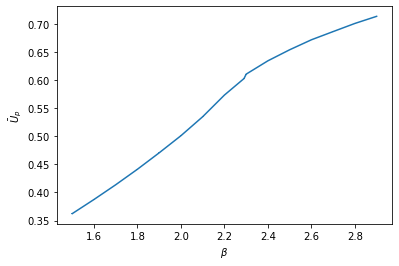

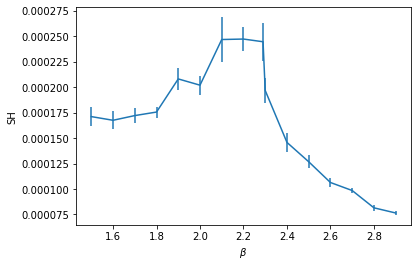

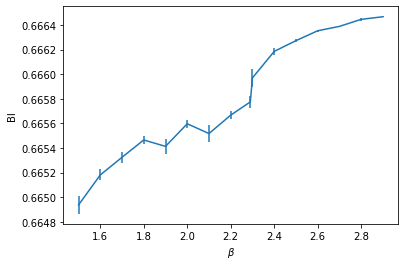

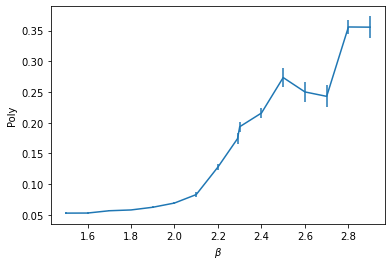

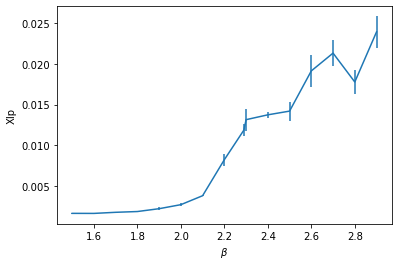

In [17]:
ana.plot_obs('Plaq', '$\\bar{U}_p$')
ana.plot_obs('SH', 'SH')
ana.plot_obs('Bl', 'Bl')
ana.plot_obs('Poly', 'Poly')
ana.plot_obs('Xlp', 'Xlp')

<ipython-input-15-36bf6dec0fb1>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,1)
<ipython-input-15-36bf6dec0fb1>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,2)
<ipython-input-15-36bf6dec0fb1>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and re

<ipython-input-15-36bf6dec0fb1>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,1)
<ipython-input-15-36bf6dec0fb1>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,2)
<ipython-input-15-36bf6dec0fb1>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and re

<ipython-input-15-36bf6dec0fb1>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,2)
<ipython-input-15-36bf6dec0fb1>:97: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,3)
<ipython-input-15-36bf6dec0fb1>:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and r

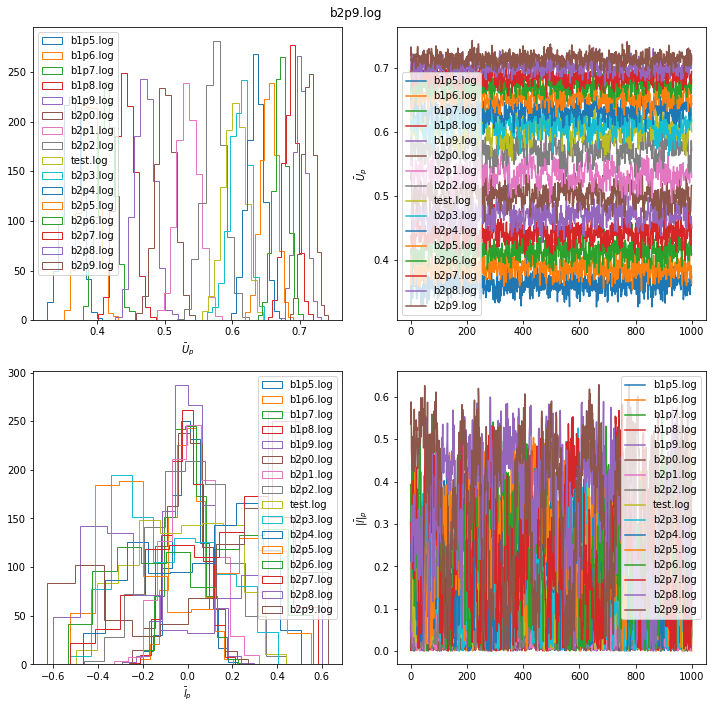

In [18]:
ana.plot_history()